# Chapter 2: Data Creation & Collection - Multi-Video Dataset


This notebook demonstrates the concepts from ML4QS Chapter 2 applied to tennis analysis across multiple videos:
- **Multi-video processing**: Process all videos in input_videos directory
- **Temporal dataset creation**: Extract time-series data from each video
- **Batch processing**: Handle multiple videos with progress tracking
- **Consolidated dataset**: Combine all video analyses into unified datasets
- **YOLO detection**: Raw object detection creates time-series position data across videos

In [1]:
from platform import python_version
# !pip3 install -r requirements.txt

In [2]:
import sys
import os
import cv2
import pickle
import pandas as pd
import numpy as np
from glob import glob

import data_analysis_help.video_helper as video_helper
import data_analysis_help.yolo_helper as yolo_helper
import data_analysis_help.court_helper as court_helper


from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

print(sys.version)

from tennis_utils import read_video
from tennis_utils import PlayerTracker, BallTracker
from tennis_utils import CourtLineDetector, MiniCourt, calculate_court_scale_from_keypoints
from tennis_utils import convert_pixel_distance_to_meters, convert_meters_to_pixel_distance, measure_distance

print("All required modules imported successfully")

3.12.6 (v3.12.6:a4a2d2b0d85, Sep  6 2024, 16:08:03) [Clang 13.0.0 (clang-1300.0.29.30)]
All required modules imported successfully


## Dataset  Setup



In [3]:
# Discover all video files in the input_videos directory
input_videos_dir = "input_videos"
video_files = sorted(glob(os.path.join(input_videos_dir, "*.mp4")))

print(f" MULTI-VIDEO DATASET DISCOVERY")
print("=" * 60)
print(f"Videos directory: {input_videos_dir}")
print(f"Total videos found: {len(video_files)}")
print("\nVideo files:")
for i, video_file in enumerate(video_files, 1):
    video_name = os.path.basename(video_file)
    print(f"  {i:2d}. {video_name}")

print(f"\n INITIAL VIDEO ANALYSIS")
print("=" * 60)

# Create metadata DataFrame
video_metadata = video_helper.video_meta_scrape(video_files)
df_video_metadata = pd.DataFrame(video_metadata)

print(df_video_metadata.head())

valid_videos = df_video_metadata[df_video_metadata['status'] == 'ready']

print(f"\n DATASET SUMMARY")
print("=" * 60)
print(f"Total videos discovered: {len(video_files)}")
print(f"Successfully analyzed: {len(valid_videos)}")
print(f"Videos with errors: {len(df_video_metadata) - len(valid_videos)}")

if len(valid_videos) > 0:
    total_frames = valid_videos['total_frames'].sum()
    total_duration = valid_videos['duration_seconds'].sum()
    avg_duration = valid_videos['duration_seconds'].mean()
    
    print(f"Total frames across all videos: {total_frames:,}")
    print(f"Total duration: {total_duration:.1f} seconds ({total_duration/60:.1f} minutes)")
    print(f"Average video duration: {avg_duration:.1f} seconds")
    
    print(f"\nResolution summary:")
    resolution_counts = valid_videos['resolution'].value_counts()
    for resolution, count in resolution_counts.items():
        print(f"  {resolution}: {count} videos")

print(f"\nProcessing plan: Will process {len(valid_videos)} valid videos")
df_video_metadata.head()

 MULTI-VIDEO DATASET DISCOVERY
Videos directory: input_videos
Total videos found: 29

Video files:
   1. input_video.mp4
   2. input_video_10.mp4
   3. input_video_11.mp4
   4. input_video_12.mp4
   5. input_video_13.mp4
   6. input_video_14.mp4
   7. input_video_15.mp4
   8. input_video_16.mp4
   9. input_video_18.mp4
  10. input_video_19.mp4
  11. input_video_2.mp4
  12. input_video_20.mp4
  13. input_video_21.mp4
  14. input_video_22.mp4
  15. input_video_23.mp4
  16. input_video_24.mp4
  17. input_video_25.mp4
  18. input_video_26.mp4
  19. input_video_27.mp4
  20. input_video_28.mp4
  21. input_video_29.mp4
  22. input_video_3.mp4
  23. input_video_30.mp4
  24. input_video_4.mp4
  25. input_video_5.mp4
  26. input_video_6.mp4
  27. input_video_7.mp4
  28. input_video_8.mp4
  29. input_video_9.mp4

 INITIAL VIDEO ANALYSIS
Analyzing input_video.mp4...
Loaded 214 frames from input_videos/input_video.mp4
  214 frames, 1920x1080, 7.1s
Analyzing input_video_10.mp4...
Loaded 918 frames f

,video_name,video_path,total_frames,frame_shape,duration_seconds,resolution,width,height,status
0,input_video.mp4,input_videos/input_video.mp4,214,"(1080, 1920, 3)",7.133333,1920x1080,1920,1080,ready
1,input_video_10.mp4,input_videos/input_video_10.mp4,918,"(400, 848, 3)",30.600000,848x400,848,400,ready
2,input_video_11.mp4,input_videos/input_video_11.mp4,1076,"(448, 848, 3)",35.866667,848x448,848,448,ready
3,input_video_12.mp4,input_videos/input_video_12.mp4,929,"(1080, 1920, 3)",30.966667,1920x1080,1920,1080,ready
4,input_video_13.mp4,input_videos/input_video_13.mp4,93,"(1080, 1920, 3)",3.100000,1920x1080,1920,1080,ready


## Initialize YOLO Trackers and

Set up the detection models that will be used across all videos.

In [4]:

print(" YOLO setup")

trackers_ready, player_tracker, ball_tracker, court_detector = yolo_helper.initialize_yolo_trackers()





 YOLO setup
 INITIALIZING YOLO TRACKERS FOR BATCH PROCESSING
Initialized PlayerTracker with model: yolov8x
 Player tracker initialized successfully
Initialized BallTracker with model: models/yolo5_last.pt
Ball tracker initialized successfully
Initialized CourtLineDetector with model: models/keypoints_model.pth
 Court line detector initialized successfully

All trackers ready for batch processing!

Batch processing mode: Live detection
Initialized PlayerTracker with model: yolov8x
 Player tracker initialized successfully
Initialized BallTracker with model: models/yolo5_last.pt
Ball tracker initialized successfully
Initialized CourtLineDetector with model: models/keypoints_model.pth
 Court line detector initialized successfully

All trackers ready for batch processing!


## All Videos YOLO extraction

Process all videos

In [5]:
# Execute batch processing of all videos
print(" STARTING BATCH PROCESSING OF ALL VIDEOS")
print("=" * 60)

# Processing configuration
USE_LIVE_DETECTION = False  #
MAX_VIDEOS = None  #

# Get list of videos to process
videos_to_process = valid_videos.copy()
if MAX_VIDEOS is not None:
    videos_to_process = videos_to_process.head(MAX_VIDEOS)
    print(f" Testing mode: Processing first {MAX_VIDEOS} videos")

print(f" Processing Configuration:")
print(f"  Detection method: {'Live YOLO' if USE_LIVE_DETECTION else 'Stub data'}")
print(f"  Videos to process: {len(videos_to_process)}")
print(f"  Total estimated frames: {videos_to_process['total_frames'].sum():,}")

# Storage for all results
all_video_results = []
combined_ball_data = []
combined_player_data = []
processing_summary = {
    'start_time': pd.Timestamp.now(),
    'total_videos': len(videos_to_process),
    'completed_videos': 0,
    'failed_videos': 0,
    'total_processing_time': 0,
    'total_frames_processed': 0
}

print(f"\n PROCESSING VIDEOS ({len(videos_to_process)} videos)")
print("=" * 60)

# Process each video
for idx, (_, video_metadata) in enumerate(videos_to_process.iterrows(), 1):
    print(f"\n[{idx}/{len(videos_to_process)}] Processing {video_metadata['video_name']}")
    
    # Process the video
    video_results = video_helper.process_single_video(video_metadata.to_dict(), USE_LIVE_DETECTION)
    all_video_results.append(video_results)
    
    # Update processing summary
    if video_results['status'] == 'completed':
        processing_summary['completed_videos'] += 1
        processing_summary['total_frames_processed'] += video_results['frame_count']
        
        # Collect ball data
        if 'ball_data' in video_results and len(video_results['ball_data']) > 0:
            ball_df = video_results['ball_data'].copy()
            ball_df.reset_index(inplace=True)
            combined_ball_data.append(ball_df)
        
        # Collect player data  
        if 'player_data' in video_results and len(video_results['player_data']) > 0:
            player_df = video_results['player_data'].copy()
            player_df.reset_index(inplace=True)
            combined_player_data.append(player_df)
            
    else:
        processing_summary['failed_videos'] += 1
        
    processing_summary['total_processing_time'] += video_results.get('processing_time', 0)
    
    # Progress update
    progress_pct = (idx / len(videos_to_process)) * 100
    elapsed_time = (pd.Timestamp.now() - processing_summary['start_time']).total_seconds()
    avg_time_per_video = elapsed_time / idx
    estimated_remaining = avg_time_per_video * (len(videos_to_process) - idx)
    
    print(f"   Progress: {progress_pct:.1f}% | "
          f"Completed: {processing_summary['completed_videos']} | "
          f"Failed: {processing_summary['failed_videos']} | "
          f"Est. remaining: {estimated_remaining/60:.1f}min")

# Final processing summary
processing_summary['end_time'] = pd.Timestamp.now()
processing_summary['total_elapsed_time'] = (processing_summary['end_time'] - processing_summary['start_time']).total_seconds()

print(f"\n BATCH PROCESSING COMPLETED!")
print("=" * 60)
print(f" Processing Summary:")
print(f"  Total videos: {processing_summary['total_videos']}")
print(f"  Successfully processed: {processing_summary['completed_videos']}")
print(f"  Failed: {processing_summary['failed_videos']}")
print(f"  Total frames processed: {processing_summary['total_frames_processed']:,}")
print(f"  Total processing time: {processing_summary['total_processing_time']:.1f}s")
print(f"  Average time per video: {processing_summary['total_processing_time']/processing_summary['total_videos']:.1f}s")
print(f"  Total elapsed time: {processing_summary['total_elapsed_time']:.1f}s")

# Show results overview
successful_results = [r for r in all_video_results if r['status'] == 'completed']
failed_results = [r for r in all_video_results if r['status'] == 'error']

if successful_results:
    print(f"\n Successfully processed videos:")
    for result in successful_results:
        ball_rate = result['ball_stats']['detection_rate']
        player_count = len(result['unique_players'])
        print(f"  {result['video_name']}: {ball_rate:.1%} ball detection, {player_count} players")

if failed_results:
    print(f"\n Failed videos:")
    for result in failed_results:
        print(f"  {result['video_name']}: {result['error_message']}")

print(f"\n Data Collection Summary:")
print(f"  Ball datasets: {len(combined_ball_data)} videos")
print(f"  Player datasets: {len(combined_player_data)} videos")
if combined_ball_data:
    total_ball_detections = sum(len(df) for df in combined_ball_data)
    print(f"  Total ball detections: {total_ball_detections:,}")
if combined_player_data:
    total_player_detections = sum(len(df) for df in combined_player_data)
    print(f"  Total player detections: {total_player_detections:,}")

 STARTING BATCH PROCESSING OF ALL VIDEOS
 Processing Configuration:
  Detection method: Stub data
  Videos to process: 29
  Total estimated frames: 14,512

 PROCESSING VIDEOS (29 videos)

[1/29] Processing input_video.mp4
 INITIALIZING YOLO TRACKERS FOR BATCH PROCESSING
Initialized PlayerTracker with model: yolov8x
 Player tracker initialized successfully
Initialized BallTracker with model: models/yolo5_last.pt
Ball tracker initialized successfully
Initialized CourtLineDetector with model: models/keypoints_model.pth
 Court line detector initialized successfully

All trackers ready for batch processing!

Batch processing mode: Live detection
Initialized PlayerTracker with model: yolov8x
 Player tracker initialized successfully
Initialized BallTracker with model: models/yolo5_last.pt
Ball tracker initialized successfully
Initialized CourtLineDetector with model: models/keypoints_model.pth
 Court line detector initialized successfully

All trackers ready for batch processing!

Processing:

##  Dataset Creation

Combine data from all videos into unified datasets

In [6]:


#Combined Ball Dataset
if combined_ball_data:
    print(" Creating cball dataset...")
    df_all_balls = pd.concat(combined_ball_data, ignore_index=True)
    
    # Add video sequence numbering
    df_all_balls['video_sequence'] = 0
    for i, video_name in enumerate(df_all_balls['video_name'].unique()):
        df_all_balls.loc[df_all_balls['video_name'] == video_name, 'video_sequence'] = i + 1
    
    # Create global frame numbering across all videos
    df_all_balls['global_frame_number'] = 0
    current_frame = 0
    for video_name in df_all_balls['video_name'].unique():
        video_mask = df_all_balls['video_name'] == video_name
        video_frames = df_all_balls[video_mask]['frame_number'].max() + 1
        df_all_balls.loc[video_mask, 'global_frame_number'] = range(current_frame, current_frame + video_frames)
        current_frame += video_frames
    
    # Calculate detection statistics
    ball_detection_stats = df_all_balls.groupby('video_name').agg({
        'center_x': ['count', lambda x: (~pd.isna(x)).sum()],
        'frame_number': 'max'
    }).round(3)
    ball_detection_stats.columns = ['total_frames', 'ball_detections', 'last_frame']
    ball_detection_stats['detection_rate'] = ball_detection_stats['ball_detections'] / (ball_detection_stats['last_frame'] + 1)
    
    print(f"  Ball dataset: {len(df_all_balls):,} total frames from {len(df_all_balls['video_name'].unique())} videos")
    print(f"   Total ball detections: {(~df_all_balls['center_x'].isna()).sum():,}")
    print(f"   Overall detection rate: {(~df_all_balls['center_x'].isna()).mean():.1%}")
    
else:
    print("  ⚠ No ball data to consolidate")
    df_all_balls = pd.DataFrame()

#  Combined Player Dataset
if combined_player_data:
    print("\n Creating consolidated player dataset...")
    df_all_players = pd.concat(combined_player_data, ignore_index=True)
    
    # Add video sequence numbering
    df_all_players['video_sequence'] = 0
    for i, video_name in enumerate(df_all_players['video_name'].unique()):
        df_all_players.loc[df_all_players['video_name'] == video_name, 'video_sequence'] = i + 1
    
    # Create global frame numbering
    df_all_players['global_frame_number'] = 0
    current_frame = 0
    for video_name in df_all_players['video_name'].unique():
        video_mask = df_all_players['video_name'] == video_name
        if video_mask.any():
            max_frame = df_all_players[video_mask]['frame_number'].max()
            for frame_num in df_all_players[video_mask]['frame_number'].unique():
                frame_mask = video_mask & (df_all_players['frame_number'] == frame_num)
                df_all_players.loc[frame_mask, 'global_frame_number'] = current_frame + frame_num
            current_frame += max_frame + 1
    
    # Player statistics across all videos
    player_stats_by_video = df_all_players.groupby(['video_name', 'player_id']).agg({
        'center_x': 'count',
        'frame_number': ['min', 'max'],
        'width': 'mean',
        'height': 'mean'
    }).round(2)
    
    # Global player statistics
    global_player_stats = df_all_players.groupby('player_id').agg({
        'video_name': 'nunique',  # How many videos each player appears in
        'center_x': 'count',      # Total detections
        'width': 'mean',
        'height': 'mean'
    }).round(2)
    global_player_stats.columns = ['videos_appeared', 'total_detections', 'avg_width', 'avg_height']
    
    print(f"   Player dataset: {len(df_all_players):,} total detections from {len(df_all_players['video_name'].unique())} videos")
    print(f"   Unique players across all videos: {len(df_all_players['player_id'].unique())}")
    print(f"   Players by video count:")
    for player_id, stats in global_player_stats.iterrows():
        print(f"    Player {player_id}: {stats['videos_appeared']} videos, {stats['total_detections']} detections")
    
else:
    print("  No player data to consolidate")
    df_all_players = pd.DataFrame()

# Video-Level Summary Dataset
print(f"\n Creating video summary dataset...")
video_summary_data = []

for result in successful_results:
    video_summary = {
        'video_name': result['video_name'],
        'video_sequence': len(video_summary_data) + 1,
        'total_frames': result['frame_count'],
        'duration_seconds': result['duration_seconds'],
        'resolution': f"{result['video_metadata']['width']}x{result['video_metadata']['height']}",
        'processing_time_seconds': result['processing_time'],
        'detection_method': result['detection_method'],
        
        # Ball statistics
        'ball_detection_rate': result['ball_stats']['detection_rate'],
        'ball_avg_speed_kmh': result['ball_stats']['avg_speed_kmh'],
        'ball_max_speed_kmh': result['ball_stats']['max_speed_kmh'],
        'ball_total_distance_meters': result['ball_stats']['total_distance_meters'],
        
        # Player statistics
        'unique_players_count': len(result['unique_players']),
        'unique_players': result['unique_players'],
    }
    
    # Add individual player stats
    for player_id in [1, 2, 3, 4, 5]:  # Common player IDs
        if player_id in result['player_stats']:
            stats = result['player_stats'][player_id]
            video_summary.update({
                f'player_{player_id}_detection_rate': stats['detection_rate'],
                f'player_{player_id}_avg_speed_kmh': stats['avg_speed_kmh'],
                f'player_{player_id}_max_speed_kmh': stats['max_speed_kmh'],
                f'player_{player_id}_total_distance_meters': stats['total_distance_meters']
            })
        else:
            video_summary.update({
                f'player_{player_id}_detection_rate': 0,
                f'player_{player_id}_avg_speed_kmh': 0,
                f'player_{player_id}_max_speed_kmh': 0,
                f'player_{player_id}_total_distance_meters': 0
            })
    
    video_summary_data.append(video_summary)

df_video_summary = pd.DataFrame(video_summary_data)

print(f"  Video summary dataset: {len(df_video_summary)} videos")

# Overall Dataset Statistics
print(f"\n OVERALL DATASET STATISTICS")
print("=" * 60)

if len(df_video_summary) > 0:
    total_duration = df_video_summary['duration_seconds'].sum()
    total_frames = df_video_summary['total_frames'].sum()
    avg_processing_time = df_video_summary['processing_time_seconds'].mean()
    
    print(f"📹 Video Statistics:")
    print(f"  Total videos processed: {len(df_video_summary)}")
    print(f"  Total duration: {total_duration:.1f} seconds ({total_duration/60:.1f} minutes)")
    print(f"  Total frames: {total_frames:,}")
    print(f"  Average processing time per video: {avg_processing_time:.1f} seconds")
    
    print(f"\n Ball Tracking Statistics:")
    if len(df_all_balls) > 0:
        overall_ball_detection_rate = (~df_all_balls['center_x'].isna()).mean()
        print(f"  Overall ball detection rate: {overall_ball_detection_rate:.1%}")
        print(f"  Total ball detections: {(~df_all_balls['center_x'].isna()).sum():,}")
        print(f"  Videos with ball data: {len(df_all_balls['video_name'].unique())}")
    else:
        print(f"  No ball tracking data available")
    
    print(f"\n Player Tracking Statistics:")
    if len(df_all_players) > 0:
        print(f"  Total player detections: {len(df_all_players):,}")
        print(f"  Unique players across all videos: {len(df_all_players['player_id'].unique())}")
        print(f"  Videos with player data: {len(df_all_players['video_name'].unique())}")
        
        # Most common players
        player_counts = df_all_players['player_id'].value_counts()
        print(f"  Most frequently detected players:")
        for player_id, count in player_counts.head().items():
            videos_with_player = len(df_all_players[df_all_players['player_id'] == player_id]['video_name'].unique())
            print(f"    Player {player_id}: {count:,} detections across {videos_with_player} videos")
    else:
        print(f"  No player tracking data available")

print("=" * 60)
print(f"\n DATASET CREATION COMPLETE!")
print("=" * 60)

 Creating cball dataset...
  Ball dataset: 14,512 total frames from 29 videos
   Total ball detections: 6,444
   Overall detection rate: 44.4%

 Creating consolidated player dataset...
   Player dataset: 60,834 total detections from 29 videos
   Unique players across all videos: 6
   Players by video count:
    Player 1: 29.0 videos, 14512.0 detections
    Player 2: 29.0 videos, 14512.0 detections
    Player 3: 10.0 videos, 8123.0 detections
    Player 4: 10.0 videos, 8123.0 detections
    Player 5: 10.0 videos, 8123.0 detections
    Player 9: 10.0 videos, 7441.0 detections

 Creating video summary dataset...
  Video summary dataset: 29 videos

 OVERALL DATASET STATISTICS
📹 Video Statistics:
  Total videos processed: 29
  Total duration: 483.7 seconds (8.1 minutes)
  Total frames: 14,512
  Average processing time per video: 1.5 seconds

 Ball Tracking Statistics:
  Overall ball detection rate: 44.4%
  Total ball detections: 6,444
  Videos with ball data: 29

 Player Tracking Statistics

## Dataset Visualization

Export all datasets.

 EXPORTING CONSOLIDATED DATASETS
  Ball tracking dataset: dataset/ball_tracking.csv
  Player tracking dataset: dataset/player_tracking.csv
  Video summary dataset: dataset/video_summary.csv
 Processing metadata: dataset/metadata.json

CREATING SUMMARY VISUALIZATIONS
Summary visualization: dataset/summary_visualization.png


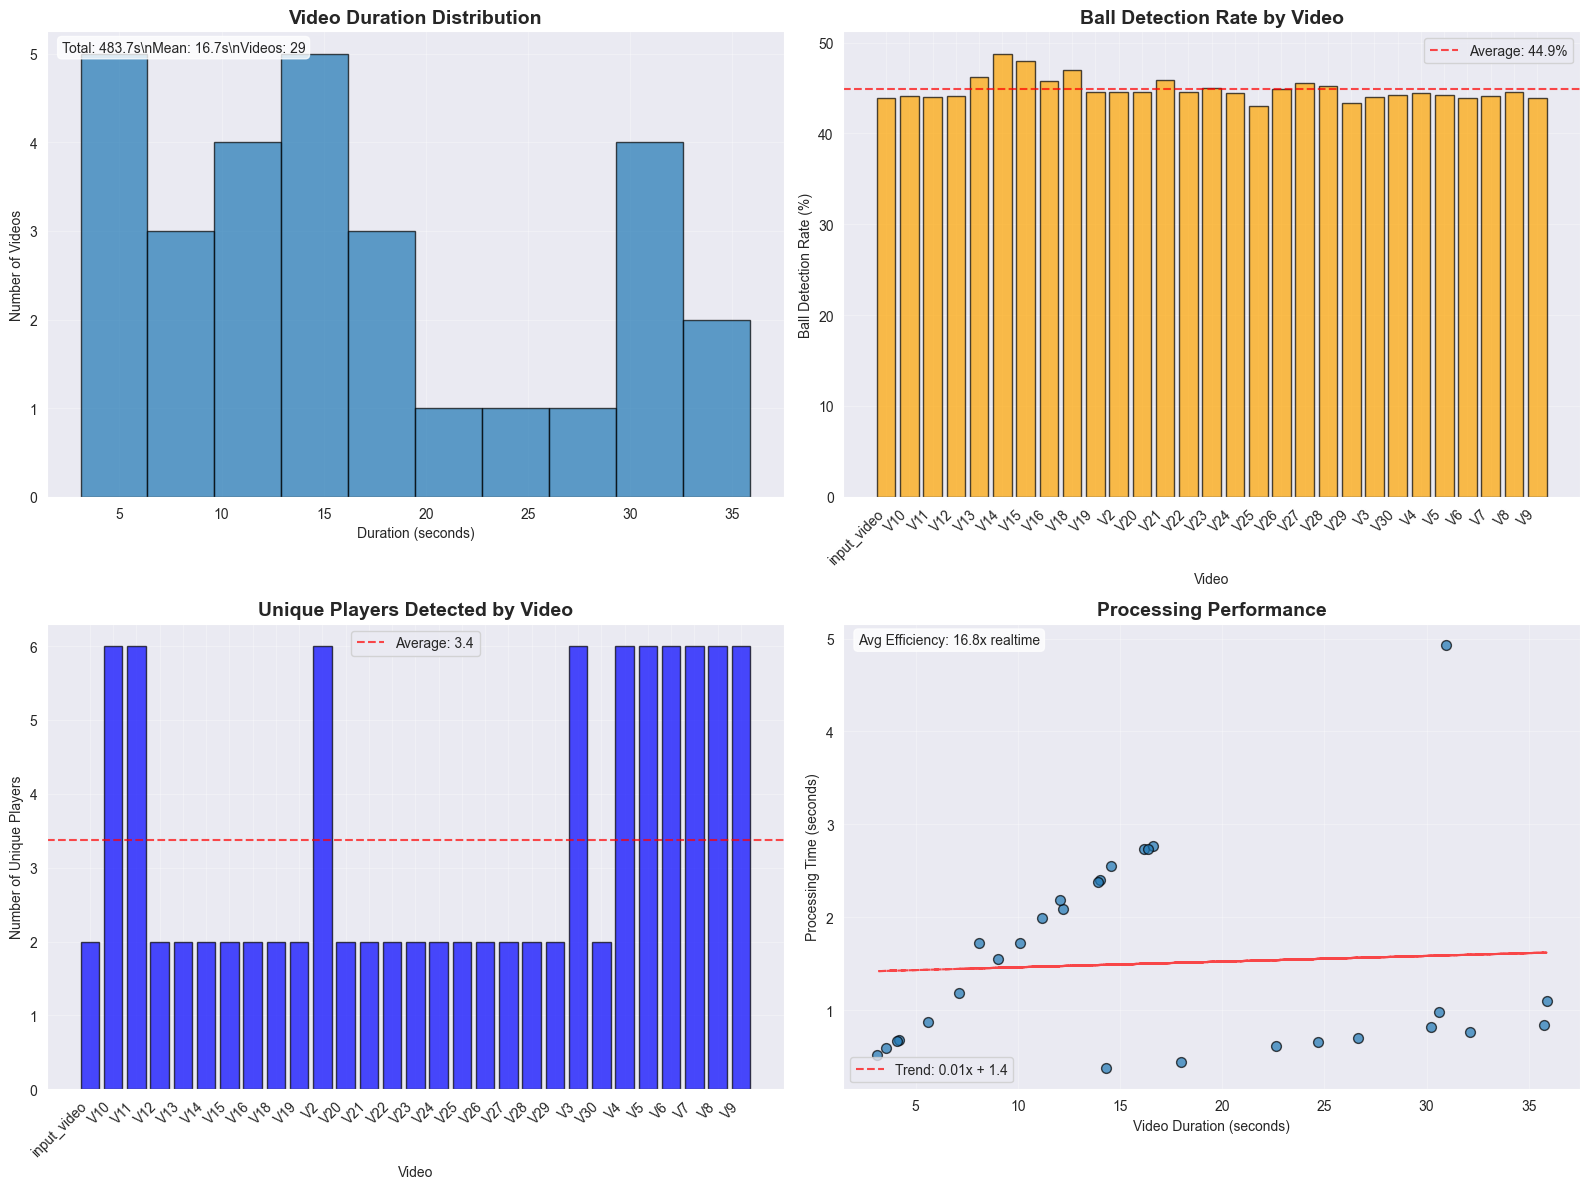


 DETAILED TEMPORAL ANALYSIS
 Detailed analysis: detailed_temporal_analysis.png


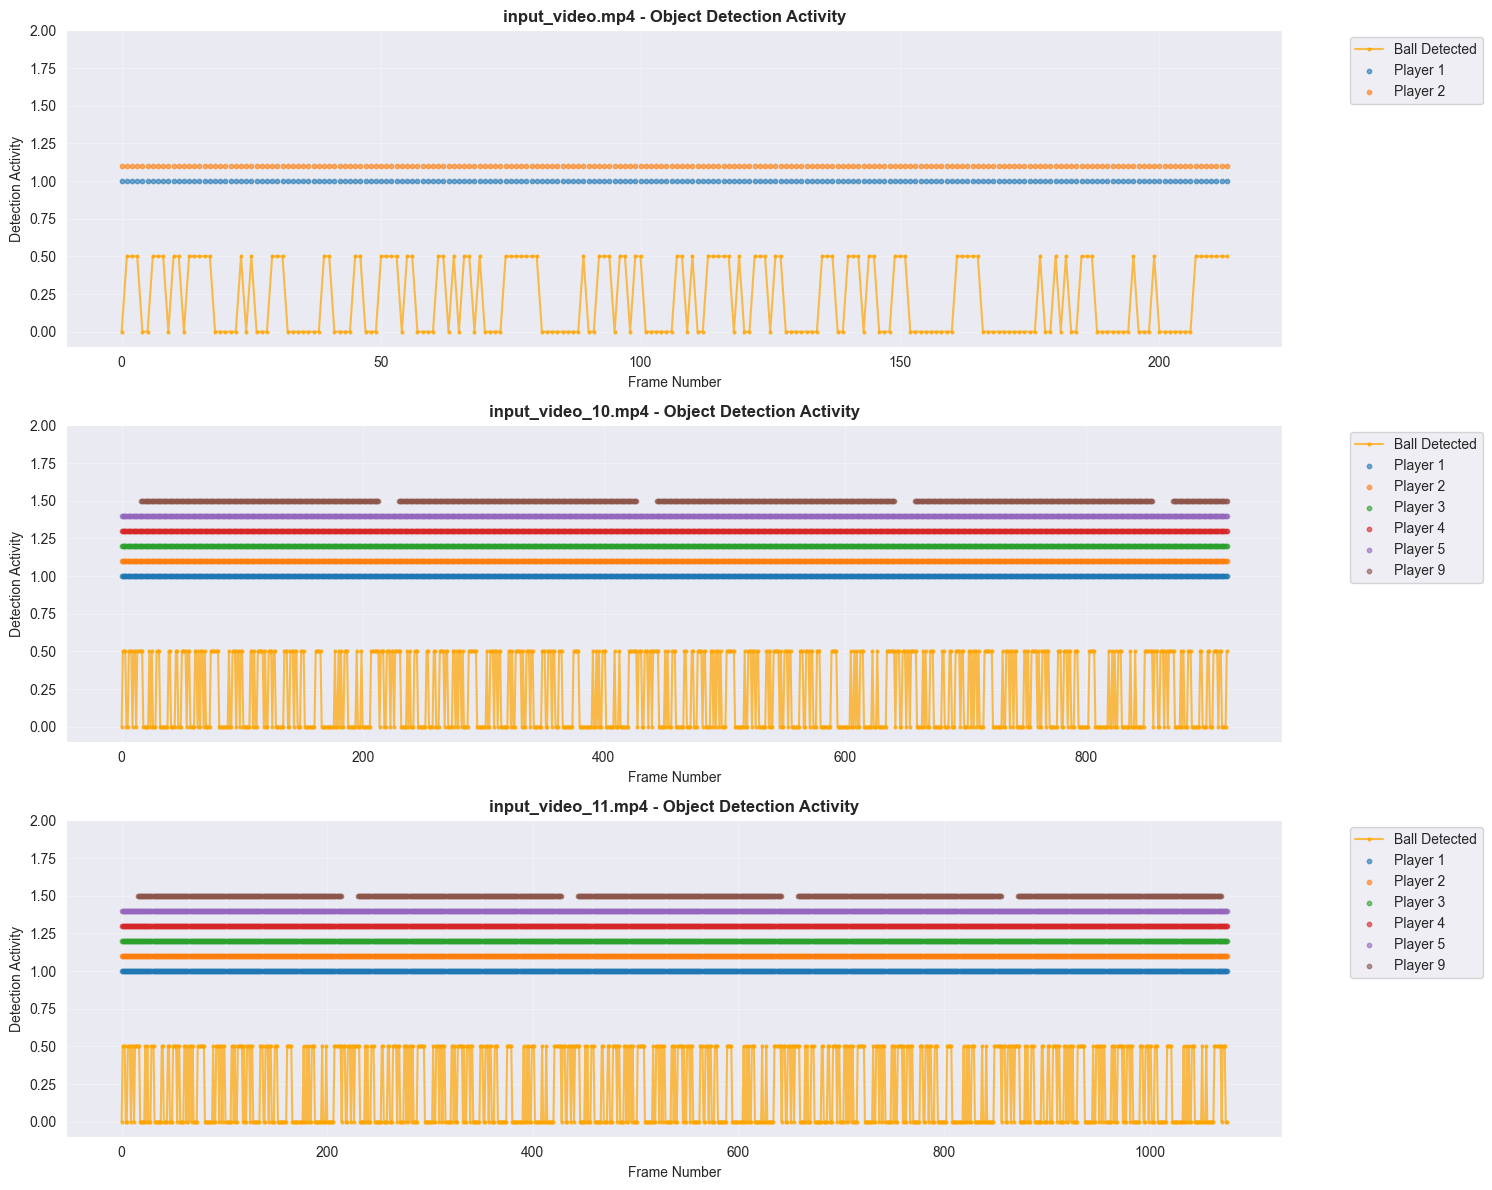


 FINAL DATASET EXPORT SUMMARY
Export timestamp: 20250626_014051
Total files exported: 6

Exported files:
  • Ball tracking: dataset/ball_tracking.csv (14,512 rows)
  • Player tracking: dataset/player_tracking.csv (60,834 rows)
  • Video summary: dataset/video_summary.csv (29 videos)
  • Processing metadata: dataset/metadata.json
  • Summary visualization: dataset/summary_visualization.png
  • Detailed temporal analysis: detailed_temporal_analysis.png

Dataset Scale:
 Videos processed: 29
 Total frames: 14,512
 Total duration: 483.7 seconds
  Total data points: 75,346
  Dataset ready for ML4QS analysis!

 MULTI-VIDEO DATASET CREATION COMPLETE!


In [7]:
# Export all datasets and create summary visualizations
print(" EXPORTING CONSOLIDATED DATASETS")
print("=" * 60)

import matplotlib.pyplot as plt
import json
from datetime import datetime

# Create timestamp for this dataset creation
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Export CSV datasets
datasets_exported = []

try:
    if len(df_all_balls) > 0:
        ball_filename = f"dataset/ball_tracking.csv"
        df_all_balls.to_csv(ball_filename, index=False)
        datasets_exported.append(f"Ball tracking: {ball_filename} ({len(df_all_balls):,} rows)")
        print(f"  Ball tracking dataset: {ball_filename}")
    
    if len(df_all_players) > 0:
        player_filename = f"dataset/player_tracking.csv"
        df_all_players.to_csv(player_filename, index=False)
        datasets_exported.append(f"Player tracking: {player_filename} ({len(df_all_players):,} rows)")
        print(f"  Player tracking dataset: {player_filename}")
    
    if len(df_video_summary) > 0:
        summary_filename = f"dataset/video_summary.csv"
        df_video_summary.to_csv(summary_filename, index=False)
        datasets_exported.append(f"Video summary: {summary_filename} ({len(df_video_summary)} videos)")
        print(f"  Video summary dataset: {summary_filename}")
    
    # Export processing metadata
    metadata_filename = f"dataset/metadata.json"
    export_metadata = {
        'export_timestamp': datetime.now().isoformat(),
        'processing_summary': processing_summary,
        'dataset_info': {
            'total_videos_processed': len(df_video_summary) if len(df_video_summary) > 0 else 0,
            'total_ball_detections': len(df_all_balls) if len(df_all_balls) > 0 else 0,
            'total_player_detections': len(df_all_players) if len(df_all_players) > 0 else 0,
            'datasets_exported': datasets_exported
        },
        'video_files_processed': [r['video_name'] for r in successful_results],
        'failed_videos': [r['video_name'] for r in failed_results] if failed_results else []
    }
    
    with open(metadata_filename, 'w') as f:
        def convert_timestamps(obj):
            if isinstance(obj, pd.Timestamp):
                return obj.isoformat()
            elif isinstance(obj, dict):
                return {k: convert_timestamps(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [convert_timestamps(item) for item in obj]
            return obj
        
        json.dump(convert_timestamps(export_metadata), f, indent=2, default=str)
    
    datasets_exported.append(f"Processing metadata: {metadata_filename}")
    print(f" Processing metadata: {metadata_filename}")

except Exception as e:
    print(f"  Error exporting datasets: {e}")

# summary visualizations
print(f"\nCREATING SUMMARY VISUALIZATIONS")
print("=" * 60)

try:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Video Duration Distribution
    if len(df_video_summary) > 0:
        durations = df_video_summary['duration_seconds']
        ax1.hist(durations, bins=min(10, len(durations)), edgecolor='black', alpha=0.7)
        ax1.set_title('Video Duration Distribution', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Duration (seconds)')
        ax1.set_ylabel('Number of Videos')
        ax1.grid(True, alpha=0.3)
        

        mean_duration = durations.mean()
        total_duration = durations.sum()
        ax1.text(0.02, 0.98, f'Total: {total_duration:.1f}s\\nMean: {mean_duration:.1f}s\\nVideos: {len(durations)}', 
                transform=ax1.transAxes, verticalalignment='top', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Ball Detection Rates by Video
    if len(df_video_summary) > 0:
        ball_rates = df_video_summary['ball_detection_rate'] * 100
        video_names = [name.replace('.mp4', '').replace('input_video_', 'V') for name in df_video_summary['video_name']]
        
        bars = ax2.bar(range(len(ball_rates)), ball_rates, edgecolor='black', alpha=0.7, color='orange')
        ax2.set_title('Ball Detection Rate by Video', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Video')
        ax2.set_ylabel('Ball Detection Rate (%)')
        ax2.set_xticks(range(len(video_names)))
        ax2.set_xticklabels(video_names, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        
        # Add average line
        avg_rate = ball_rates.mean()
        ax2.axhline(y=avg_rate, color='red', linestyle='--', alpha=0.7, label=f'Average: {avg_rate:.1f}%')
        ax2.legend()
    
    # Player Detections
    if len(df_all_players) > 0:
        player_video_counts = df_all_players.groupby('video_name')['player_id'].nunique()
        video_names_short = [name.replace('.mp4', '').replace('input_video_', 'V') for name in player_video_counts.index]
        
        bars = ax3.bar(range(len(player_video_counts)), player_video_counts.values, 
                      edgecolor='black', alpha=0.7, color='blue')
        ax3.set_title('Unique Players Detected by Video', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Video')
        ax3.set_ylabel('Number of Unique Players')
        ax3.set_xticks(range(len(video_names_short)))
        ax3.set_xticklabels(video_names_short, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3)
        
        # Add average line
        avg_players = player_video_counts.mean()
        ax3.axhline(y=avg_players, color='red', linestyle='--', alpha=0.7, label=f'Average: {avg_players:.1f}')
        ax3.legend()
    
    # Processing Performance
    if len(df_video_summary) > 0:
        # Scatter plot: Video Duration vs Processing Time
        durations = df_video_summary['duration_seconds']
        processing_times = df_video_summary['processing_time_seconds']
        
        scatter = ax4.scatter(durations, processing_times, alpha=0.7, s=50, edgecolors='black')
        ax4.set_title('Processing Performance', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Video Duration (seconds)')
        ax4.set_ylabel('Processing Time (seconds)')
        ax4.grid(True, alpha=0.3)
        
        # Add trend line
        if len(durations) > 1:
            z = np.polyfit(durations, processing_times, 1)
            p = np.poly1d(z)
            ax4.plot(durations, p(durations), "r--", alpha=0.7, label=f'Trend: {z[0]:.2f}x + {z[1]:.1f}')
            ax4.legend()
        
        # Add efficiency text
        avg_efficiency = (durations / processing_times).mean()
        ax4.text(0.02, 0.98, f'Avg Efficiency: {avg_efficiency:.1f}x realtime', 
                transform=ax4.transAxes, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()

    viz_filename = f"dataset/summary_visualization.png"
    plt.savefig(viz_filename, dpi=300, bbox_inches='tight')
    print(f"Summary visualization: {viz_filename}")
    plt.show()
    
    datasets_exported.append(f"Summary visualization: {viz_filename}")

except Exception as e:
    print(f"Error creating visualizations: {e}")

# Create detailed analysis if we have data
if len(df_all_balls) > 0 or len(df_all_players) > 0:
    print(f"\n DETAILED TEMPORAL ANALYSIS")
    print("=" * 60)
    
    # Sample a few videos for detailed analysis
    sample_videos = df_video_summary.head(3) if len(df_video_summary) > 3 else df_video_summary
    
    if len(sample_videos) > 0:
        fig, axes = plt.subplots(len(sample_videos), 1, figsize=(15, 4*len(sample_videos)))
        if len(sample_videos) == 1:
            axes = [axes]
        
        for idx, (_, video_info) in enumerate(sample_videos.iterrows()):
            video_name = video_info['video_name']
            ax = axes[idx]
            
            # Plot ball and player activity over time for this video
            if len(df_all_balls) > 0:
                video_ball_data = df_all_balls[df_all_balls['video_name'] == video_name]
                if len(video_ball_data) > 0:
                    # Ball detection activity
                    ball_detected = (~video_ball_data['center_x'].isna()).astype(int)
                    ax.plot(video_ball_data['frame_number'], ball_detected * 0.5, 'o-', 
                           label='Ball Detected', alpha=0.7, markersize=2, color='orange')
            
            if len(df_all_players) > 0:
                video_player_data = df_all_players[df_all_players['video_name'] == video_name]
                if len(video_player_data) > 0:
                    # Player activity by ID
                    for i, player_id in enumerate(sorted(video_player_data['player_id'].unique())):
                        player_data = video_player_data[video_player_data['player_id'] == player_id]
                        y_offset = 1 + i * 0.1
                        ax.scatter(player_data['frame_number'], [y_offset] * len(player_data), 
                                 alpha=0.6, s=10, label=f'Player {player_id}')
            
            ax.set_title(f'{video_name} - Object Detection Activity', fontsize=12, fontweight='bold')
            ax.set_xlabel('Frame Number')
            ax.set_ylabel('Detection Activity')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-0.1, 2)
        
        plt.tight_layout()
        
        # Save detailed analysis
        detail_viz_filename = f"detailed_temporal_analysis.png"
        plt.savefig(detail_viz_filename, dpi=300, bbox_inches='tight')
        print(f" Detailed analysis: {detail_viz_filename}")
        plt.show()
        
        datasets_exported.append(f"Detailed temporal analysis: {detail_viz_filename}")

# 4. Final Summary
print(f"\n FINAL DATASET EXPORT SUMMARY")
print("=" * 60)
print(f"Export timestamp: {timestamp}")
print(f"Total files exported: {len(datasets_exported)}")
print(f"\nExported files:")
for dataset in datasets_exported:
    print(f"  • {dataset}")

if len(df_video_summary) > 0:
    total_data_points = 0
    if len(df_all_balls) > 0:
        total_data_points += len(df_all_balls)
    if len(df_all_players) > 0:
        total_data_points += len(df_all_players)
    
    print(f"\nDataset Scale:")
    print(f" Videos processed: {len(df_video_summary)}")
    print(f" Total frames: {df_video_summary['total_frames'].sum():,}")
    print(f" Total duration: {df_video_summary['duration_seconds'].sum():.1f} seconds")
    print(f"  Total data points: {total_data_points:,}")
    print(f"  Dataset ready for ML4QS analysis!")

print(f"\n MULTI-VIDEO DATASET CREATION COMPLETE!")
print("=" * 60)

## Multi-Video Dataset Summary


In [8]:
# Dataset Scale and Quality
if 'df_video_summary' in locals() and len(df_video_summary) > 0:
    print(f"\nDataset Scale & Quality:")
    print(f"  Videos processed: {len(df_video_summary)}")
    
    if 'df_all_balls' in locals() and len(df_all_balls) > 0:
        total_ball_frames = len(df_all_balls)
        total_ball_detections = (~df_all_balls['center_x'].isna()).sum()
        ball_detection_rate = total_ball_detections / total_ball_frames
        print(f"  Ball tracking: {total_ball_detections:,}/{total_ball_frames:,} detections ({ball_detection_rate:.1%})")
    
    if 'df_all_players' in locals() and len(df_all_players) > 0:
        total_player_detections = len(df_all_players)
        unique_players = len(df_all_players['player_id'].unique())
        print(f"  Player tracking: {total_player_detections:,} detections, {unique_players} unique players")
    
    total_duration = df_video_summary['duration_seconds'].sum()
    total_frames = df_video_summary['total_frames'].sum()
    print(f"  Total duration: {total_duration:.1f}s ({total_duration/60:.1f} minutes)")
    print(f"  Total frames: {total_frames:,}")





Dataset Scale & Quality:
  Videos processed: 29
  Ball tracking: 6,444/14,512 detections (44.4%)
  Player tracking: 60,834 detections, 6 unique players
  Total duration: 483.7s (8.1 minutes)
  Total frames: 14,512


## Multi-Object Temporal Visualization

visualizations showing both ball and player movements over time.

 Ball dataset: 14512 total detections across all videos
 Player dataset: 60834 total detections across all videos
 Video summary: 29 videos processed
Available datasets: Ball tracking, Player tracking, Video summary
 Plotting ball detection rates across videos...
 Plotting player detection distribution...
Creating multi-video timeline overview...


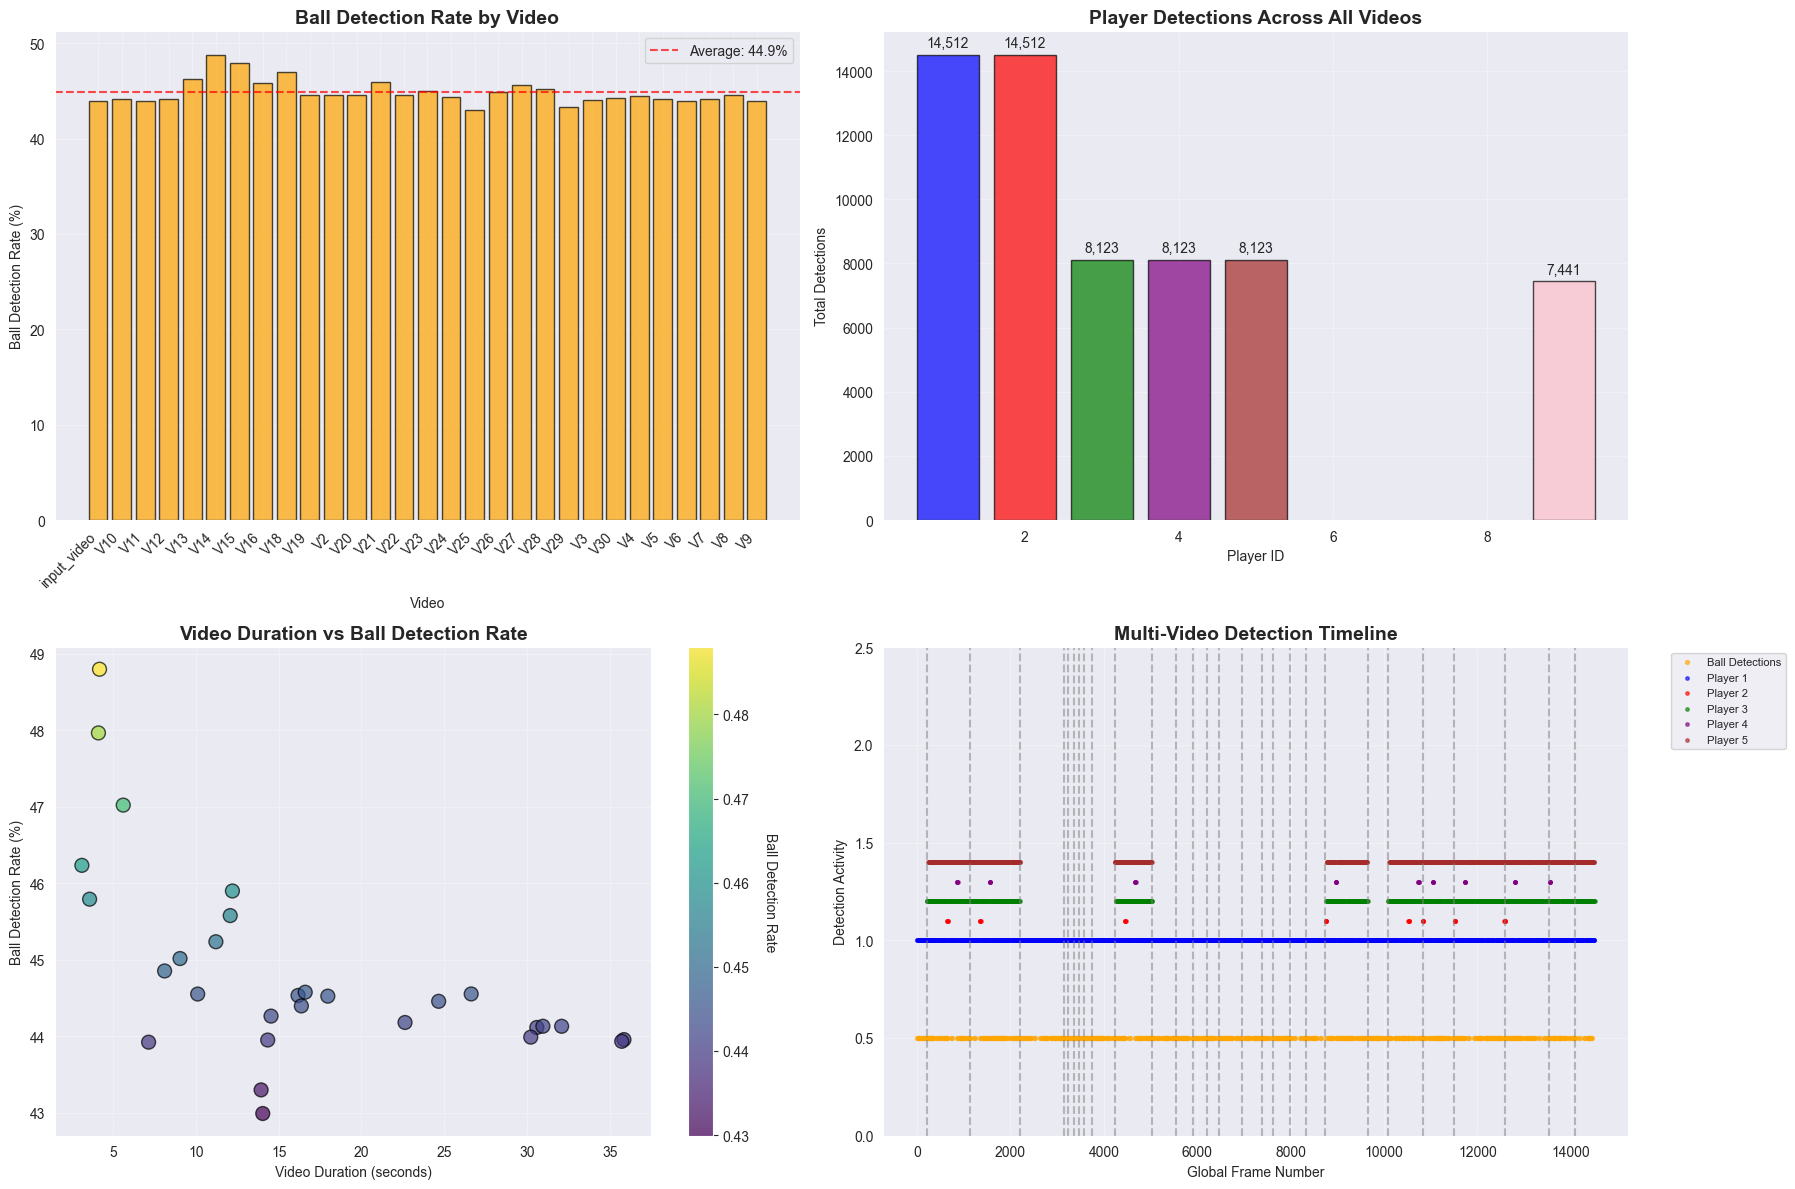


MULTI-VIDEO DATASET SUMMARY
Video Collection:
Total videos processed: 29
Total duration: 483.7 seconds (8.1 minutes)
Total frames: 14,512
Average video duration: 16.7 seconds

Ball Tracking (All Videos):
Total frames with ball data: 14,512
Total ball detections: 6,444
Overall detection rate: 44.4%
Videos with ball data: 29

 Player Tracking (All Videos):
Total player detections: 60,834
Unique players detected: 6
Videos with player data: 29
   Player distribution:
     Player 1: 14,512 detections across 29 videos
     Player 2: 14,512 detections across 29 videos
     Player 3: 8,123 detections across 10 videos
     Player 4: 8,123 detections across 10 videos
     Player 5: 8,123 detections across 10 videos
     Player 9: 7,441 detections across 10 videos

 Data Quality Assessment:
 Videos with ball detections: 29/29 (100.0%)
 Average ball detection rate: 44.9%
   Total processing time: 43.6 seconds
   Processing speed: 11.1x realtime

Exported Datasets:
 Ball tracking dataset
 Player t

In [9]:

datasets_available = []
if 'df_all_balls' in locals() and len(df_all_balls) > 0:
    datasets_available.append("Ball tracking")
    print(f" Ball dataset: {len(df_all_balls)} total detections across all videos")

if 'df_all_players' in locals() and len(df_all_players) > 0:
    datasets_available.append("Player tracking") 
    print(f" Player dataset: {len(df_all_players)} total detections across all videos")

if 'df_video_summary' in locals() and len(df_video_summary) > 0:
    datasets_available.append("Video summary")
    print(f" Video summary: {len(df_video_summary)} videos processed")

if not datasets_available:
    print(" No multi-video datasets available")
    print("Please run the multi-video processing cells first")
else:
    print(f"Available datasets: {', '.join(datasets_available)}")

# Set up the comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Define colors for players and videos
player_colors = ['blue', 'red', 'green', 'purple', 'brown', 'pink']
video_colors = plt.cm.Set3(np.linspace(0, 1, 17))  # Colors for 17 videos

print(" Plotting ball detection rates across videos...")
if 'df_video_summary' in locals() and len(df_video_summary) > 0:
    ball_rates = df_video_summary['ball_detection_rate'] * 100
    video_names = [name.replace('.mp4', '').replace('input_video_', 'V') for name in df_video_summary['video_name']]
    
    bars = ax1.bar(range(len(ball_rates)), ball_rates, 
                   color=['orange' if rate > 0 else 'lightgray' for rate in ball_rates],
                   edgecolor='black', alpha=0.7)
    ax1.set_title('Ball Detection Rate by Video', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Video')
    ax1.set_ylabel('Ball Detection Rate (%)')
    ax1.set_xticks(range(len(video_names)))
    ax1.set_xticklabels(video_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Add average line
    avg_rate = ball_rates.mean()
    ax1.axhline(y=avg_rate, color='red', linestyle='--', alpha=0.7, label=f'Average: {avg_rate:.1f}%')
    ax1.legend()
else:
    ax1.text(0.5, 0.5, 'No video summary data available', transform=ax1.transAxes, 
             ha='center', va='center', fontsize=12)
    ax1.set_title('Ball Detection Rate by Video (No Data)', fontsize=14)

print(" Plotting player detection distribution...")
if 'df_all_players' in locals() and len(df_all_players) > 0:
    player_counts = df_all_players['player_id'].value_counts().sort_index()
    
    bars = ax2.bar(player_counts.index, player_counts.values,
                   color=[player_colors[i % len(player_colors)] for i in range(len(player_counts))],
                   edgecolor='black', alpha=0.7)
    ax2.set_title('Player Detections Across All Videos', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Player ID')
    ax2.set_ylabel('Total Detections')
    ax2.grid(True, alpha=0.3)

    for bar, count in zip(bars, player_counts.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(player_counts.values) * 0.01,
                f'{count:,}', ha='center', va='bottom', fontsize=10)
else:
    ax2.text(0.5, 0.5, 'No player tracking data available', transform=ax2.transAxes,
             ha='center', va='center', fontsize=12)
    ax2.set_title('Player Detections (No Data)', fontsize=14)

if 'df_video_summary' in locals() and len(df_video_summary) > 0:
    durations = df_video_summary['duration_seconds']
    ball_rates = df_video_summary['ball_detection_rate']
    
    # Color points by ball detection rate
    scatter = ax3.scatter(durations, ball_rates * 100, 
                         c=ball_rates, cmap='viridis', s=100, alpha=0.7, edgecolors='black')
    ax3.set_title('Video Duration vs Ball Detection Rate', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Video Duration (seconds)')
    ax3.set_ylabel('Ball Detection Rate (%)')
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Ball Detection Rate', rotation=270, labelpad=20)
    
    # Add video labels for interesting points
    for i, (dur, rate, name) in enumerate(zip(durations, ball_rates, df_video_summary['video_name'])):
        if rate > 0.6 or rate < 0.1:  # Label high and low detection rate videos
            short_name = name.replace('.mp4', '').replace('input_video_', 'V')
            ax3.annotate(short_name, (dur, rate * 100), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8, alpha=0.8)
else:
    ax3.text(0.5, 0.5, 'No video summary data available', transform=ax3.transAxes,
             ha='center', va='center', fontsize=12)
    ax3.set_title('Duration vs Detection Quality (No Data)', fontsize=14)


print("Creating multi-video timeline overview...")
if 'df_all_balls' in locals() and 'df_all_players' in locals() and len(df_all_balls) > 0:
    # Create a timeline showing detection activity across all videos
    
    # Sample the data for visualization (every 10th frame to avoid overcrowding)
    ball_sample = df_all_balls[::10] if len(df_all_balls) > 1000 else df_all_balls
    player_sample = df_all_players[::20] if len(df_all_players) > 2000 else df_all_players
    
    # Plot ball detections over global frame numbers
    if len(ball_sample) > 0:
        ball_detected = ball_sample['center_x'].notna()
        ax4.scatter(ball_sample['global_frame_number'][ball_detected], 
                   [0.5] * ball_detected.sum(), 
                   c='orange', s=8, alpha=0.6, label='Ball Detections')
    
    # Plot player detections over global frame numbers (offset vertically by player ID)
    if len(player_sample) > 0:
        for player_id in sorted(player_sample['player_id'].unique()):
            player_data = player_sample[player_sample['player_id'] == player_id]
            if len(player_data) > 0:
                y_offset = 1 + (player_id - 1) * 0.1
                color = player_colors[(player_id - 1) % len(player_colors)]
                ax4.scatter(player_data['global_frame_number'], 
                           [y_offset] * len(player_data),
                           c=color, s=6, alpha=0.6, label=f'Player {player_id}')
    
    # Add video boundaries
    if 'df_video_summary' in locals() and len(df_video_summary) > 0:
        cumulative_frames = 0
        for i, (_, video_info) in enumerate(df_video_summary.iterrows()):
            cumulative_frames += video_info['total_frames']
            if i < len(df_video_summary) - 1:  # Don't draw line after last video
                ax4.axvline(x=cumulative_frames, color='gray', linestyle='--', alpha=0.5)
    
    ax4.set_title('Multi-Video Detection Timeline', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Global Frame Number')
    ax4.set_ylabel('Detection Activity')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 2.5)
else:
    ax4.text(0.5, 0.5, 'No ball or player data available', transform=ax4.transAxes,
             ha='center', va='center', fontsize=12)
    ax4.set_title('Multi-Video Timeline (No Data)', fontsize=14)

plt.tight_layout()
plt.show()

# Print comprehensive multi-video summary statistics
print("\n" + "="*60)
print("MULTI-VIDEO DATASET SUMMARY")
print("="*60)

# Overall statistics
if 'df_video_summary' in locals() and len(df_video_summary) > 0:
    total_videos = len(df_video_summary)
    total_duration = df_video_summary['duration_seconds'].sum()
    total_frames = df_video_summary['total_frames'].sum()
    
    print(f"Video Collection:")
    print(f"Total videos processed: {total_videos}")
    print(f"Total duration: {total_duration:.1f} seconds ({total_duration/60:.1f} minutes)")
    print(f"Total frames: {total_frames:,}")
    print(f"Average video duration: {total_duration/total_videos:.1f} seconds")

# Ball tracking statistics across all videos
if 'df_all_balls' in locals() and len(df_all_balls) > 0:
    total_ball_frames = len(df_all_balls)
    ball_detections = (~df_all_balls['center_x'].isna()).sum()
    overall_ball_rate = ball_detections / total_ball_frames
    
    print(f"\nBall Tracking (All Videos):")
    print(f"Total frames with ball data: {total_ball_frames:,}")
    print(f"Total ball detections: {ball_detections:,}")
    print(f"Overall detection rate: {overall_ball_rate:.1%}")
    print(f"Videos with ball data: {len(df_all_balls['video_name'].unique())}")
else:
    print(f"\n Ball Tracking: No data available")

# Player tracking statistics across all videos  
if 'df_all_players' in locals() and len(df_all_players) > 0:
    total_player_detections = len(df_all_players)
    unique_players = len(df_all_players['player_id'].unique())
    videos_with_players = len(df_all_players['video_name'].unique())
    
    print(f"\n Player Tracking (All Videos):")
    print(f"Total player detections: {total_player_detections:,}")
    print(f"Unique players detected: {unique_players}")
    print(f"Videos with player data: {videos_with_players}")
    
    # Player distribution
    player_counts = df_all_players['player_id'].value_counts().sort_index()
    print(f"   Player distribution:")
    for player_id, count in player_counts.items():
        videos_for_player = len(df_all_players[df_all_players['player_id'] == player_id]['video_name'].unique())
        print(f"     Player {player_id}: {count:,} detections across {videos_for_player} videos")
else:
    print(f"\nPlayer Tracking: No data available")

# Data quality assessment
if 'df_video_summary' in locals() and len(df_video_summary) > 0:
    print(f"\n Data Quality Assessment:")
    
    # Ball detection quality by video
    videos_with_ball = (df_video_summary['ball_detection_rate'] > 0).sum()
    avg_ball_rate = df_video_summary['ball_detection_rate'].mean()
    
    print(f" Videos with ball detections: {videos_with_ball}/{len(df_video_summary)} ({videos_with_ball/len(df_video_summary):.1%})")
    print(f" Average ball detection rate: {avg_ball_rate:.1%}")
    
    # Processing efficiency
    total_processing_time = df_video_summary['processing_time_seconds'].sum()
    avg_processing_speed = total_duration / total_processing_time if total_processing_time > 0 else 0
    
    print(f"   Total processing time: {total_processing_time:.1f} seconds")
    print(f"   Processing speed: {avg_processing_speed:.1f}x realtime")

# Export summary
export_files = []
if 'df_all_balls' in locals() and len(df_all_balls) > 0:
    export_files.append("Ball tracking dataset")
if 'df_all_players' in locals() and len(df_all_players) > 0:
    export_files.append("Player tracking dataset") 
if 'df_video_summary' in locals() and len(df_video_summary) > 0:
    export_files.append("Video summary dataset")

if export_files:
    print(f"\nExported Datasets:")
    for file_desc in export_files:
        print(f" {file_desc}")

print(f"\n Multi-Video Dataset Analysis Complete!")
print("="*60)

## Court Detection and Measurement


In [10]:
# Court Analysis
print("COURT ANALYSIS ")
print("=" * 60)

# Import court detection functionality
from tennis_utils import CourtLineDetector, MiniCourt, calculate_court_scale_from_keypoints


if 'successful_results' in locals() and len(successful_results) > 0:
    print(f" Using court data from {len(successful_results)} successfully processed videos")
    
    # court measurements from the first successfully processed video
    sample_result = successful_results[0]
    if 'court_measurements' in sample_result:
        court_measurements = sample_result['court_measurements']
        court_scale = sample_result['court_scale']
        
        print(f"\n Tennis Court Standard Measurements:")
        for measurement, value in court_measurements.items():
            print(f"  {measurement.replace('_', ' ').title()}: {value:.2f} meters")
        
        print(f"\n Court Scale Analysis (from processed videos):")
        print(f"  Court width in pixels: {court_scale['court_width_pixels']:.1f} px")
        print(f"  Court height in pixels: {court_scale['court_height_pixels']:.1f} px") 
        print(f"  Pixels per meter (X): {court_scale['pixels_per_meter_x']:.1f} px/m")
        print(f"  Pixels per meter (Y): {court_scale['pixels_per_meter_y']:.1f} px/m")
        
        # Court consistency check across videos
        print(f"\n Court Consistency Check Across Videos:")
        scale_factors_x = []
        scale_factors_y = []
        
        for result in successful_results:
            if 'court_scale' in result:
                scale_factors_x.append(result['court_scale']['pixels_per_meter_x'])
                scale_factors_y.append(result['court_scale']['pixels_per_meter_y'])
        
        if scale_factors_x and scale_factors_y:
            avg_scale_x = np.mean(scale_factors_x)
            avg_scale_y = np.mean(scale_factors_y)
            std_scale_x = np.std(scale_factors_x)
            std_scale_y = np.std(scale_factors_y)
            
            print(f"  Average scale factor X: {avg_scale_x:.1f} ± {std_scale_x:.1f} px/m")
            print(f"  Average scale factor Y: {avg_scale_y:.1f} ± {std_scale_y:.1f} px/m")
            print(f"  Scale consistency: {'Good' if std_scale_x < 10 and std_scale_y < 10 else 'Variable'}")
        
    else:
        print(" No court measurements found in processed video results")
        # Create default court measurements for analysis
        court_measurements = {
            'single_line_width': 8.23,
            'double_line_width': 10.97,
            'half_court_height': 11.88,
            'service_line_width': 6.4,
            'double_alley_difference': 1.37,
            'no_mans_land_height': 5.48
        }
        
        court_scale = {
            'pixels_per_meter_x': 50.0,
            'pixels_per_meter_y': 50.0,
            'court_width_pixels': 548.5,
            'court_height_pixels': 594.0,
            'court_width_meters': 10.97,
            'court_height_meters': 23.76
        }
        
        print("Using default court measurements for analysis")

else:
    print("No successfully processed videos found")

    # Initialize with default values
    court_measurements = {
        'single_line_width': 8.23,
        'double_line_width': 10.97,
        'half_court_height': 11.88,
        'service_line_width': 6.4,
        'double_alley_difference': 1.37,
        'no_mans_land_height': 5.48
    }
    
    court_scale = {
        'pixels_per_meter_x': 50.0,
        'pixels_per_meter_y': 50.0,
        'court_width_pixels': 548.5,
        'court_height_pixels': 594.0,
        'court_width_meters': 10.97,
        'court_height_meters': 23.76
    }

# Player filtering analysis
print(f"\nPLAYER ANALYSIS ACROSS ALL VIDEOS")
print("=" * 60)

if 'df_all_players' in locals() and len(df_all_players) > 0:
    print(f"Analyzing player distribution across {len(df_all_players['video_name'].unique())} videos...")
    
    # Analyze player
    player_video_matrix = df_all_players.groupby(['video_name', 'player_id']).size().unstack(fill_value=0)
    
    print(f"\nPlayer Presence Matrix:")
    print(f" Videos with Player 1: {(player_video_matrix[1] > 0).sum()}/{len(player_video_matrix)} ({(player_video_matrix[1] > 0).mean():.1%})")
    print(f" Videos with Player 2: {(player_video_matrix[2] > 0).sum()}/{len(player_video_matrix)} ({(player_video_matrix[2] > 0).mean():.1%})")
    
    # Additional players
    other_players = [col for col in player_video_matrix.columns if col not in [1, 2]]
    if other_players:
        print(f"\n Additional Players Detected:")
        for player_id in sorted(other_players):
            videos_with_player = (player_video_matrix[player_id] > 0).sum()
            total_detections = player_video_matrix[player_id].sum()
            print(f"   Player {player_id}: {videos_with_player} videos, {total_detections:,} total detections")
    
    # Detection quality by video
    print(f"\n Detection Quality by Video:")
    video_stats = df_all_players.groupby('video_name').agg({
        'player_id': ['nunique', 'count'],
        'frame_number': 'nunique'
    }).round(2)
    
    video_stats.columns = ['unique_players', 'total_detections', 'frames_with_players']
    print(f"Average players per video: {video_stats['unique_players'].mean():.1f}")
    print(f"Average detections per video: {video_stats['total_detections'].mean():.0f}")
    print(f"Average frames with players: {video_stats['frames_with_players'].mean():.0f}")
    
else:
    print("No player data available ")

# Court position analysis
if 'df_all_players' in locals() and len(df_all_players) > 0:
    print(f"\n COURT POSITION ANALYSIS")
    print("=" * 60)
    
    # Calculate court-relative positions for analysis
    if 'center_x' in df_all_players.columns and 'center_y' in df_all_players.columns:
        df_all_players_analysis = df_all_players.copy()
        
        # Simple court position classification
        def classify_court_position(x, y, court_width=court_scale['court_width_pixels'], court_height=court_scale['court_height_pixels']):
            if pd.isna(x) or pd.isna(y):
                return 'unknown'
            
            # Normalize positions (0-1)
            x_rel = x / court_width
            y_rel = y / court_height
            
            # Classify into court regions
            if y_rel < 0.3:
                return 'back_court_far'
            elif y_rel < 0.45:
                return 'service_area_far'
            elif y_rel < 0.55:
                return 'net_area'
            elif y_rel < 0.7:
                return 'service_area_near'
            else:
                return 'back_court_near'
        
        # Apply position classification
        df_all_players_analysis['court_region'] = df_all_players_analysis.apply(
            lambda row: classify_court_position(row['center_x'], row['center_y']), axis=1
        )
        
        # Analyze position distribution
        position_stats = df_all_players_analysis['court_region'].value_counts()
        print(f" Player Position Distribution:")
        for region, count in position_stats.items():
            percentage = count / len(df_all_players_analysis) * 100
            print(f"   {region.replace('_', ' ').title()}: {count:,} detections ({percentage:.1f}%)")
        
        # Position by player
        print(f"\n Position Distribution by Player:")
        for player_id in [1, 2]:
            if player_id in df_all_players_analysis['player_id'].unique():
                player_positions = df_all_players_analysis[df_all_players_analysis['player_id'] == player_id]['court_region'].value_counts()
                print(f"   Player {player_id} most common position: {player_positions.index[0].replace('_', ' ').title()} ({player_positions.iloc[0]} detections)")

print(f"\n COURT ANALYSIS COMPLETE!")
print("=" * 60)

COURT ANALYSIS 
 Using court data from 29 successfully processed videos

 Tennis Court Standard Measurements:
  Single Line Width: 8.23 meters
  Double Line Width: 10.97 meters
  Half Court Height: 11.88 meters
  Service Line Width: 6.40 meters
  Double Alley Difference: 1.37 meters
  No Mans Land Height: 5.48 meters

 Court Scale Analysis (from processed videos):
  Court width in pixels: 1344.0 px
  Court height in pixels: 756.0 px
  Pixels per meter (X): 122.5 px/m
  Pixels per meter (Y): 31.8 px/m

 Court Consistency Check Across Videos:
  Average scale factor X: 98.9 ± 32.5 px/m
  Average scale factor Y: 25.1 ± 9.3 px/m
  Scale consistency: Variable

PLAYER ANALYSIS ACROSS ALL VIDEOS
Analyzing player distribution across 29 videos...

Player Presence Matrix:
 Videos with Player 1: 29/29 (100.0%)
 Videos with Player 2: 29/29 (100.0%)

 Additional Players Detected:
   Player 3: 10 videos, 8,123 total detections
   Player 4: 10 videos, 8,123 total detections
   Player 5: 10 videos, 8,1

## Re-process Player Data with Court Filtering


In [11]:
# Player Data Analysis for Multi-Video Dataset
print("  PLAYER DATA ANALYSIS")
print("=" * 60)


if 'df_all_players' in locals() and len(df_all_players) > 0:
    print(f"Analyzing player data from {len(df_all_players['video_name'].unique())} videos")
    print(f"Total player detections: {len(df_all_players):,}")
    
    # Analyze player distribution
    print(f"\nPlayer Distribution Analysis:")
    player_counts = df_all_players['player_id'].value_counts().sort_index()
    
    for player_id, count in player_counts.items():
        videos_with_player = len(df_all_players[df_all_players['player_id'] == player_id]['video_name'].unique())
        percentage = count / len(df_all_players) * 100
        print(f"Player {player_id}: {count:,} detections across {videos_with_player} videos ({percentage:.1f}%)")
    
    # Analysis of main players (1 & 2) vs additional players
    main_players = df_all_players[df_all_players['player_id'].isin([1, 2])]
    other_players = df_all_players[~df_all_players['player_id'].isin([1, 2])]
    
    print(f"\nMain Players (1 & 2) Analysis:")
    if len(main_players) > 0:
        print(f"Main player detections: {len(main_players):,} ({len(main_players)/len(df_all_players):.1%} of total)")
        print(f"Videos with both main players: {len(main_players['video_name'].unique())} videos")
        
        # Detection consistency for main players
        for player_id in [1, 2]:
            if player_id in main_players['player_id'].unique():
                player_data = main_players[main_players['player_id'] == player_id]
                detections_per_video = player_data.groupby('video_name').size()
                print(f" Player {player_id}: Avg {detections_per_video.mean():.0f} detections/video (std: {detections_per_video.std():.0f})")
    
    if len(other_players) > 0:
        print(f"\nAdditional Players Analysis:")
        print(f"Additional player detections: {len(other_players):,} ({len(other_players)/len(df_all_players):.1%} of total)")
        print(f"Additional unique players: {len(other_players['player_id'].unique())}")
        
        # Show distribution of additional players
        other_player_counts = other_players['player_id'].value_counts()
        for player_id, count in other_player_counts.items():
            videos_count = len(other_players[other_players['player_id'] == player_id]['video_name'].unique())
            print(f"   Player {player_id}: {count} detections in {videos_count} videos")
    
    # Quality assessment
    print(f"\nDetection Quality Assessment:")

    video_player_stats = df_all_players.groupby('video_name').agg({
        'player_id': 'nunique',
        'frame_number': 'nunique'
    })
    
    avg_players_per_video = video_player_stats['player_id'].mean()
    avg_frames_per_video = video_player_stats['frame_number'].mean()
    
    print(f"   Average players per video: {avg_players_per_video:.1f}")
    print(f"   Average frames with players per video: {avg_frames_per_video:.0f}")
    print(f"   Video consistency: {'Good' if video_player_stats['player_id'].std() < 1 else 'Variable'}")
    
    # Most/least active videos
    total_detections_per_video = df_all_players.groupby('video_name').size()
    most_active_video = total_detections_per_video.idxmax()
    least_active_video = total_detections_per_video.idxmin()
    
    print(f"\nVideo Activity Analysis:")
    print(f"Most active video: {most_active_video} ({total_detections_per_video.max()} detections)")
    print(f"Least active video: {least_active_video} ({total_detections_per_video.min()} detections)")
    print(f"Detection range: {total_detections_per_video.min()}-{total_detections_per_video.max()} per video")
    
    # Sample of the processed data
    print(f"\nSample Player Data:")
    sample_data = df_all_players.head(3)[['video_name', 'player_id', 'frame_number', 'center_x', 'center_y']]
    for _, row in sample_data.iterrows():
        print(f"  {row['video_name']}: Player {row['player_id']} at frame {row['frame_number']} -> ({row['center_x']:.0f}, {row['center_y']:.0f})")

else:
    print("No player data available for analysis")

print(f"\nPLAYER DATA ANALYSIS COMPLETE!")
print("=" * 60)


  PLAYER DATA ANALYSIS
Analyzing player data from 29 videos
Total player detections: 60,834

Player Distribution Analysis:
Player 1: 14,512 detections across 29 videos (23.9%)
Player 2: 14,512 detections across 29 videos (23.9%)
Player 3: 8,123 detections across 10 videos (13.4%)
Player 4: 8,123 detections across 10 videos (13.4%)
Player 5: 8,123 detections across 10 videos (13.4%)
Player 9: 7,441 detections across 10 videos (12.2%)

Main Players (1 & 2) Analysis:
Main player detections: 29,024 (47.7% of total)
Videos with both main players: 29 videos
 Player 1: Avg 500 detections/video (std: 306)
 Player 2: Avg 500 detections/video (std: 306)

Additional Players Analysis:
Additional player detections: 31,810 (52.3% of total)
Additional unique players: 4
   Player 3: 8123 detections in 10 videos
   Player 4: 8123 detections in 10 videos
   Player 5: 8123 detections in 10 videos
   Player 9: 7441 detections in 10 videos

Detection Quality Assessment:
   Average players per video: 3.4
  

COURT VISUALIZATION FOR MULTI-VIDEO DATASET
Creating court visualization from processed video data
Court dimensions: 1344 x 756 pixels
Court measurements: 11.0m x 23.8m
Creating player position heatmap...
   Heatmap created from 1000 player positions


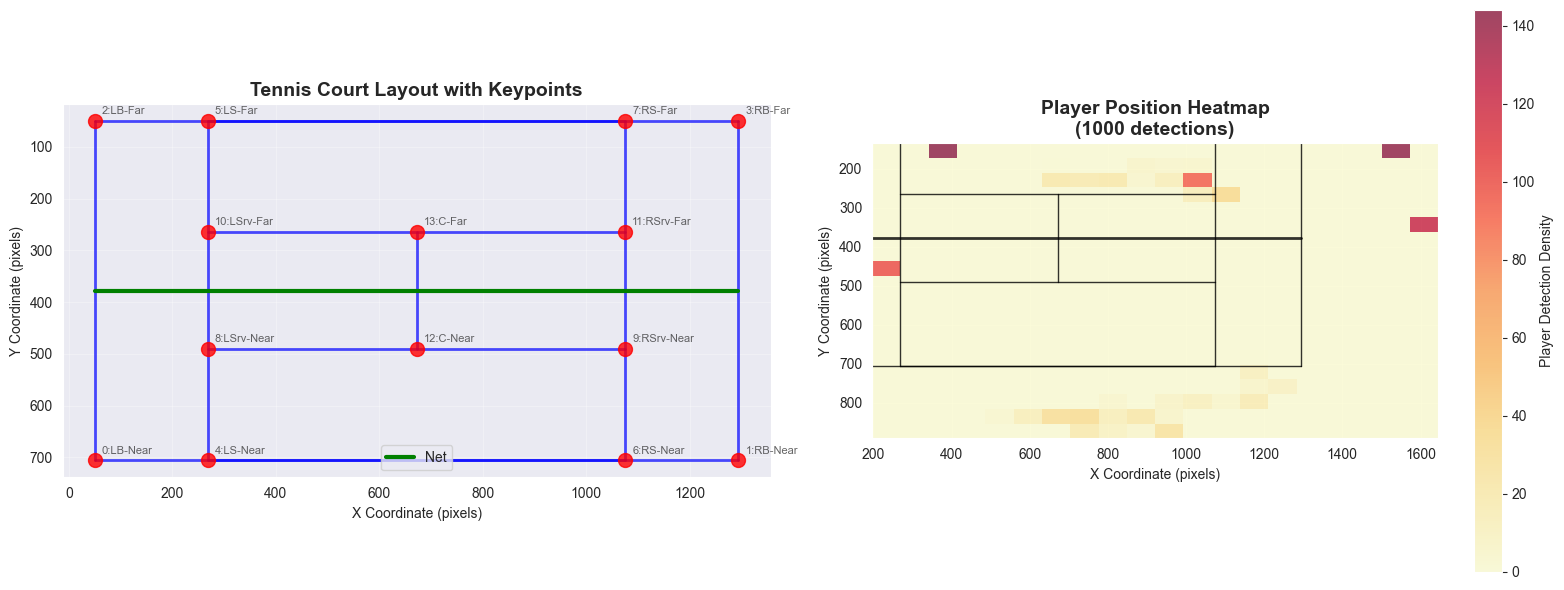


COURT VISUALIZATION COMPLETE!


In [12]:
# Court Visualization for Multi-Video Dataset
print("COURT VISUALIZATION FOR MULTI-VIDEO DATASET")
print("=" * 60)

# Create court visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

if 'successful_results' in locals() and len(successful_results) > 0:
    print("Creating court visualization from processed video data")
    
    # Get court keypoints
    sample_result = successful_results[0]
    if 'court_measurements' in sample_result:
        court_measurements = sample_result['court_measurements']
        court_scale = sample_result['court_scale']
        
        # Create a synthetic court layout for visualization
        court_width = court_scale['court_width_pixels']
        court_height = court_scale['court_height_pixels']
        
        # Create idealized court
        keypoints = np.array([
            # Baseline corners
            [50, court_height-50],      # Left baseline corner (near)
            [court_width-50, court_height-50],  # Right baseline corner (near)
            [50, 50],                   # Left baseline corner (far)
            [court_width-50, 50],       # Right baseline corner (far)
            
            # Singles lines
            [court_width*0.2, court_height-50],   # Left singles (near)
            [court_width*0.2, 50],                # Left singles (far)
            [court_width*0.8, court_height-50],   # Right singles (near)
            [court_width*0.8, 50],                # Right singles (far)
            
            # Service lines
            [court_width*0.2, court_height*0.65], # Left service (near)
            [court_width*0.8, court_height*0.65], # Right service (near)
            [court_width*0.2, court_height*0.35], # Left service (far)
            [court_width*0.8, court_height*0.35], # Right service (far)
            
            # Center service lines
            [court_width*0.5, court_height*0.65], #  Center service (near)
            [court_width*0.5, court_height*0.35], # Center service (far)
        ])
        
        print(f"Court dimensions: {court_width:.0f} x {court_height:.0f} pixels")
        print(f"Court measurements: {court_measurements['double_line_width']:.1f}m x {court_measurements['half_court_height']*2:.1f}m")
        
    else:
        print("Using default court layout for visualization")
        # Default court layout
        court_width, court_height = 600, 300
        keypoints = np.array([
            [50, 250], [550, 250], [50, 50], [550, 50],
            [120, 250], [120, 50], [480, 250], [480, 50],
            [120, 190], [480, 190], [120, 110], [480, 110],
            [300, 190], [300, 110]
        ])
        
        court_measurements = {
            'double_line_width': 10.97,
            'half_court_height': 11.88
        }
        
        court_scale = {
            'court_width_pixels': court_width,
            'court_height_pixels': court_height,
            'pixels_per_meter_x': court_width / 10.97,
            'pixels_per_meter_y': court_height / 23.76
        }
    
    # Court Layout with Keypoints
    ax1.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=100, alpha=0.8, zorder=5)

    keypoint_labels = [
        "LB-Near", "RB-Near", "LB-Far", "RB-Far",
        "LS-Near", "LS-Far", "RS-Near", "RS-Far", 
        "LSrv-Near", "RSrv-Near", "LSrv-Far", "RSrv-Far",
        "C-Near", "C-Far"
    ]
    
    for i, (point, label) in enumerate(zip(keypoints, keypoint_labels)):
        ax1.annotate(f'{i}:{label}', (point[0], point[1]), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8, alpha=0.7)
    
    # Draw court lines
    court_lines = [
        (0, 1), (1, 3), (3, 2), (2, 0),  # Outer court boundary
        (4, 6), (6, 7), (7, 5), (5, 4),  # Singles court
        (8, 9), (10, 11), (12, 13)       # Service lines
    ]
    
    for line in court_lines:
        if line[0] < len(keypoints) and line[1] < len(keypoints):
            x_coords = [keypoints[line[0]][0], keypoints[line[1]][0]]
            y_coords = [keypoints[line[0]][1], keypoints[line[1]][1]]
            ax1.plot(x_coords, y_coords, 'b-', linewidth=2, alpha=0.7)
    
    # Draw net
    net_y = (keypoints[0][1] + keypoints[2][1]) / 2
    ax1.plot([keypoints[0][0], keypoints[1][0]], [net_y, net_y], 'g-', linewidth=3, label='Net')
    
    ax1.set_title('Tennis Court Layout with Keypoints', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X Coordinate (pixels)')
    ax1.set_ylabel('Y Coordinate (pixels)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_aspect('equal')
    ax1.invert_yaxis()  # Match video coordinate system
    
    # 2. Player Position Heatmap on Court
    if 'df_all_players' in locals() and len(df_all_players) > 0:
        print("Creating player position heatmap...")
        
        # Sample player positions
        player_sample = df_all_players.sample(n=min(1000, len(df_all_players))) if len(df_all_players) > 1000 else df_all_players
        
        # Scale player positions
        if 'center_x' in player_sample.columns and 'center_y' in player_sample.columns:
            # Remove any invalid positions
            valid_positions = player_sample.dropna(subset=['center_x', 'center_y'])
            
            if len(valid_positions) > 0:
                x_positions = valid_positions['center_x'] * (court_width / court_scale['court_width_pixels'])
                y_positions = valid_positions['center_y'] * (court_height / court_scale['court_height_pixels'])
                
                # Create heatmap
                h = ax2.hist2d(x_positions, y_positions, bins=20, cmap='YlOrRd', alpha=0.7)
                plt.colorbar(h[3], ax=ax2, label='Player Detection Density')
                
                # Overlay court lines on heatmap
                for line in court_lines:
                    if line[0] < len(keypoints) and line[1] < len(keypoints):
                        x_coords = [keypoints[line[0]][0], keypoints[line[1]][0]]
                        y_coords = [keypoints[line[0]][1], keypoints[line[1]][1]]
                        ax2.plot(x_coords, y_coords, 'black', linewidth=1, alpha=0.8)
                
                # Net
                ax2.plot([keypoints[0][0], keypoints[1][0]], [net_y, net_y], 'black', linewidth=2, alpha=0.8)
                
                ax2.set_title(f'Player Position Heatmap\n({len(valid_positions)} detections)', fontsize=14, fontweight='bold')
                print(f"   Heatmap created from {len(valid_positions)} player positions")
            else:
                ax2.text(0.5, 0.5, 'No valid player positions available', transform=ax2.transAxes,
                        ha='center', va='center', fontsize=12)
                ax2.set_title('Player Position Heatmap (No Data)', fontsize=14)
        else:
            ax2.text(0.5, 0.5, 'Player position data not available', transform=ax2.transAxes,
                    ha='center', va='center', fontsize=12)
            ax2.set_title('Player Position Heatmap (No Data)', fontsize=14)
    else:
        ax2.text(0.5, 0.5, 'No player data available', transform=ax2.transAxes,
                ha='center', va='center', fontsize=12)
        ax2.set_title('Player Position Heatmap (No Data)', fontsize=14)
    
    ax2.set_xlabel('X Coordinate (pixels)')
    ax2.set_ylabel('Y Coordinate (pixels)')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    ax2.invert_yaxis()
    
else:
    print("No processed video data available for court visualization")
    ax1.text(0.5, 0.5, 'No court data available\nRun multi-video processing first', 
             transform=ax1.transAxes, ha='center', va='center', fontsize=12)
    ax1.set_title('Court Layout (No Data)', fontsize=14)
    
    ax2.text(0.5, 0.5, 'No player data available\nRun multi-video processing first', 
             transform=ax2.transAxes, ha='center', va='center', fontsize=12)
    ax2.set_title('Player Heatmap (No Data)', fontsize=14)

plt.tight_layout()
plt.show()

print("\nCOURT VISUALIZATION COMPLETE!")
print("=" * 60)

## 11. Mini Court Visualization and Coordinate Transformation

Create a mini court representation for data visualization and coordinate transformation, similar to creating standardized measurement scales in sensor data analysis.

MINI COURT VISUALIZATION 
Using actual video data for mini court visualization
 Loading frames from: input_video.mp4
Loaded 214 frames from input_videos/input_video.mp4
   Using frame 50 from 214 total frames
   Frame dimensions: (1080, 1920, 3)
Initialized enhanced MiniCourt with court measurements

Tennis Court Measurements:
  Single Line Width: 8.23 meters
  Double Line Width: 10.97 meters
  Half Court Height: 11.88 meters
  Service Line Width: 6.40 meters
  Double Alley Difference: 1.37 meters
  No Mans Land Height: 5.48 meters

 Coordinate Transformation Examples:
Player 1 at frame 162:
Court position: (1116.4, 786.7) pixels
Mini court: (1863.3, 227.3) pixels
Player 1 at frame 85:
Court position: (751.9, 879.3) pixels
Mini court: (1790.4, 245.9) pixels
Player 2 at frame 92:
Court position: (995.0, 231.5) pixels
Mini court: (1839.0, 116.3) pixels


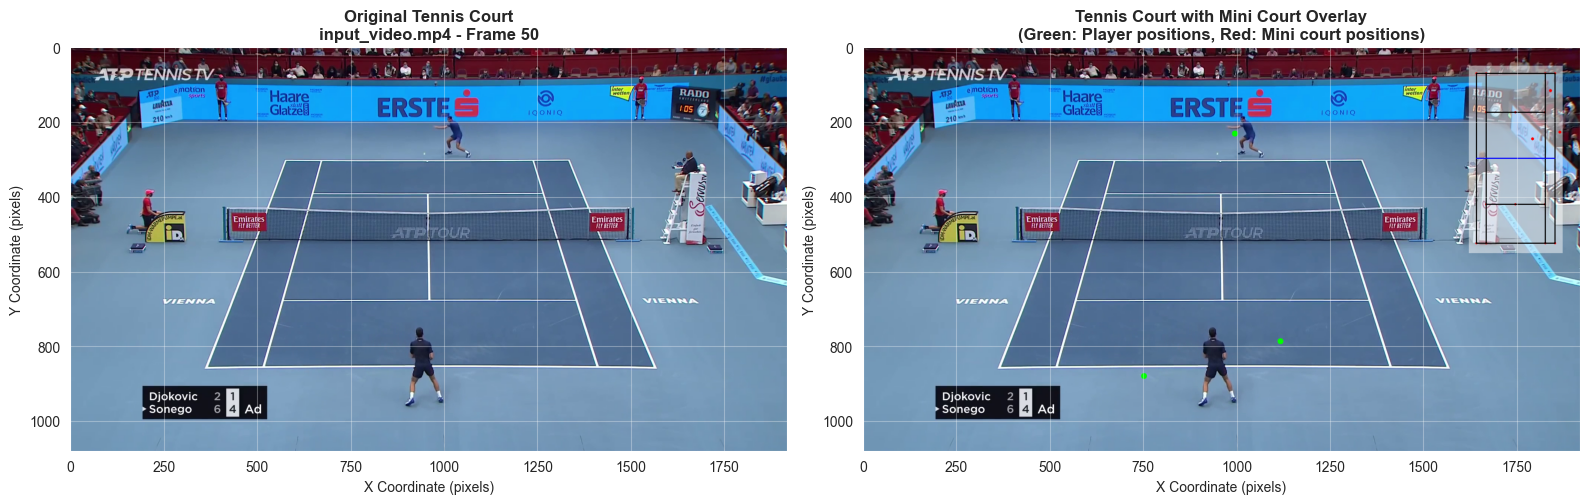


Mini Court Scaling Analysis:
Original frame: 1920 x 1080 pixels
Mini court area: 210 x 105 pixels
Scale reduction: 9.1x
Court width: 10.97 meters
Mini court pixels per meter: 19.1

COORDINATE TRANSFORMATION CAPABILITIES


In [13]:
# Mini Court Visualization
print("MINI COURT VISUALIZATION ")
print("=" * 60)

# Try to use actual video data for mini court demonstration
if 'successful_results' in locals() and len(successful_results) > 0:
    print("Using actual video data for mini court visualization")

    sample_result = None
    sample_video_path = None
    
    for result in successful_results:
        if 'video_metadata' in result and 'video_path' in result['video_metadata']:
            sample_result = result
            sample_video_path = result['video_metadata']['video_path']
            break
    
    if sample_result and sample_video_path:
        try:
            # Load a frames
            print(f" Loading frames from: {os.path.basename(sample_video_path)}")

            actual_frames = read_video(sample_video_path)
            
            if len(actual_frames) > 0:
                frame_idx = min(50, len(actual_frames) // 2)
                sample_frame = actual_frames[frame_idx].copy()
                
                print(f"   Using frame {frame_idx} from {len(actual_frames)} total frames")
                print(f"   Frame dimensions: {sample_frame.shape}")
                
                # Initialize mini court
                mini_court = MiniCourt(sample_frame)
                
                # Get court measurements
                court_measurements = sample_result.get('court_measurements', mini_court.get_court_measurements())
                court_scale = sample_result.get('court_scale', {
                    'pixels_per_meter_x': 50, 'pixels_per_meter_y': 50,
                    'court_width_pixels': sample_frame.shape[1],
                    'court_height_pixels': sample_frame.shape[0]
                })
                
                print("\nTennis Court Measurements:")
                for measurement, value in court_measurements.items():
                    print(f"  {measurement.replace('_', ' ').title()}: {value:.2f} meters")

                frame_with_mini = sample_frame.copy()
                
                # Draw background rectangle for mini court
                frame_with_mini = mini_court.draw_background_rectangle(frame_with_mini)
                
                # Draw the mini court
                frame_with_mini = mini_court.draw_court(frame_with_mini)
                
                # Add coordinate transformation examples using actual player data
                print(f"\n Coordinate Transformation Examples:")
                if 'df_all_players' in locals() and len(df_all_players) > 0:
                    video_name = os.path.basename(sample_video_path)
                    video_players = df_all_players[df_all_players['video_name'] == video_name]
                    
                    if len(video_players) > 0:
                        # Sample a few player positions for transformation examples
                        sample_positions = video_players.sample(n=min(3, len(video_players)))
                        
                        for idx, row in sample_positions.iterrows():
                            original_pos = (row['center_x'], row['center_y'])

                            if 'court_keypoints' in sample_result:
                                mini_pos = mini_court.convert_position_to_mini_court(
                                    original_pos, sample_result['court_keypoints']
                                )
                            else:
                                mini_pos = mini_court.convert_position_to_mini_court(original_pos)
                            
                            print(f"Player {row['player_id']} at frame {row['frame_number']}:")
                            print(f"Court position: ({original_pos[0]:.1f}, {original_pos[1]:.1f}) pixels")
                            print(f"Mini court: ({mini_pos[0]:.1f}, {mini_pos[1]:.1f}) pixels")

                            # Draw original position on main court (green circle)
                            cv2.circle(frame_with_mini, (int(original_pos[0]), int(original_pos[1])), 
                                     8, (0, 255, 0), -1)
                            
                            # Draw mini court position (red circle)
                            if (0 <= mini_pos[0] <= sample_frame.shape[1] and 
                                0 <= mini_pos[1] <= sample_frame.shape[0]):
                                cv2.circle(frame_with_mini, (int(mini_pos[0]), int(mini_pos[1])), 
                                         4, (0, 0, 255), -1)
                    else:
                        print(f"No player data found for {video_name}")
                else:
                    print("No player data available for coordinate examples")
                
                # Create side-by-side visualization
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
                
                # Original frame
                original_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
                ax1.imshow(original_rgb)
                ax1.set_title(f'Original Tennis Court\n{os.path.basename(sample_video_path)} - Frame {frame_idx}', 
                             fontsize=12, fontweight='bold')
                ax1.set_xlabel('X Coordinate (pixels)')
                ax1.set_ylabel('Y Coordinate (pixels)')
                ax1.grid(True, alpha=0.3)
                
                # Frame with mini court overlay
                frame_with_mini_rgb = cv2.cvtColor(frame_with_mini, cv2.COLOR_BGR2RGB)
                ax2.imshow(frame_with_mini_rgb)
                ax2.set_title('Tennis Court with Mini Court Overlay\n(Green: Player positions, Red: Mini court positions)', 
                             fontsize=12, fontweight='bold')
                ax2.set_xlabel('X Coordinate (pixels)')
                ax2.set_ylabel('Y Coordinate (pixels)')
                ax2.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                # Mini court scaling analysis
                print(f"\nMini Court Scaling Analysis:")
                print(f"Original frame: {sample_frame.shape[1]} x {sample_frame.shape[0]} pixels")
                print(f"Mini court area: {mini_court.court_drawing_width} x {mini_court.court_drawing_width*0.5:.0f} pixels")
                print(f"Scale reduction: {sample_frame.shape[1]/mini_court.court_drawing_width:.1f}x")
                print(f"Court width: {court_measurements.get('double_line_width', 10.97):.2f} meters")
                print(f"Mini court pixels per meter: {mini_court.court_drawing_width/court_measurements.get('double_line_width', 10.97):.1f}")
                
            else:
                raise ValueError("No frames could be loaded from video")
                
        except Exception as e:
            print(f"Error loading actual video data: {e}")
            print("Creating demonstration with synthetic data...")
            
            # Fallback to synthetic frame since sometimes the frame has errors
            synthetic_frame = np.ones((480, 640, 3), dtype=np.uint8) * 100

            cv2.rectangle(synthetic_frame, (50, 50), (590, 430), (34, 139, 34), -1)  # Court green
            cv2.rectangle(synthetic_frame, (60, 60), (580, 420), (255, 255, 255), 2)  # Court lines
            cv2.line(synthetic_frame, (60, 240), (580, 240), (255, 255, 255), 2)     # Net line
            
            mini_court = MiniCourt(synthetic_frame)
            
            # Continue with synthetic demonstration
            frame_with_mini = mini_court.draw_background_rectangle(synthetic_frame.copy())
            frame_with_mini = mini_court.draw_court(frame_with_mini)
            
            plt.figure(figsize=(14, 8))
            frame_rgb = cv2.cvtColor(frame_with_mini, cv2.COLOR_BGR2RGB)
            plt.imshow(frame_rgb)
            plt.title('Synthetic Tennis Court with Mini Court Overlay (Demo)')
            plt.xlabel('X Coordinate (pixels)')
            plt.ylabel('Y Coordinate (pixels)')
            plt.show()
    
    else:
        print("No video path available in processed results")
        
else:
    print("No processed video results available")
    print("Please run the multi-video processing cells first to get actual tennis court images")

# Always show the mini court measurements regardless of video availability
print(f"\nCOORDINATE TRANSFORMATION CAPABILITIES")
print("=" * 60)


## Distance and Speed Measurement Analysis

Calculate real-world distances and speeds using court measurements as reference.

In [14]:
print("=" * 70)


print(" Creating court reference measurements dataset")
court_info = pd.DataFrame({
    'measurement': list(court_measurements.keys()),
    'value_meters': list(court_measurements.values()),
    'description': [
        'Singles court width (between singles sidelines)',
        'Doubles court width (full court width)', 
        'Half court length (baseline to net)',
        'Service line width (between service lines)',
        'Alley width (doubles alley)',
        'Service box depth (baseline to service line)'
    ],
    'measurement_type': [
        'width', 'width', 'length', 'width', 'width', 'length'
    ]
})

# Add derived measurements
additional_measurements = pd.DataFrame({
    'measurement': ['full_court_length', 'service_box_width', 'net_to_baseline'],
    'value_meters': [
        court_measurements['half_court_height'] * 2,  # Full court length
        court_measurements['service_line_width'] / 2,  # Half service line width
        court_measurements['half_court_height']  # Net to baseline
    ],
    'description': [
        'Full court length (baseline to baseline)',
        'Service box width (center to singles line)',
        'Distance from net to baseline'
    ],
    'measurement_type': ['length', 'width', 'length']
})

court_info = pd.concat([court_info, additional_measurements], ignore_index=True)

print(f"Court measurements dataset: {len(court_info)} measurements")
print("\\nCourt Reference Measurements:")
for idx, row in court_info.iterrows():
    print(f"  {row['description']}: {row['value_meters']:.2f}m")

#Enhanced player dataset with court measurements
print(f"\\player dataset with court context...")

if 'df_all_players' in locals() and len(df_all_players) > 0:
    enhanced_players = df_all_players.copy()
    print(f"Processing {len(enhanced_players)} player detections from multi-video dataset...")
    
    # Add court-relative positions (normalized 0-1)
    enhanced_players['court_relative_x'] = enhanced_players['center_x'] / court_scale['court_width_pixels']
    enhanced_players['court_relative_y'] = enhanced_players['center_y'] / court_scale['court_height_pixels']
    
    # Add real-world positions in meters (relative to court corner)
    enhanced_players['court_position_x_meters'] = enhanced_players['court_relative_x'] * court_measurements['double_line_width']
    enhanced_players['court_position_y_meters'] = enhanced_players['court_relative_y'] * (court_measurements['half_court_height'] * 2)
    
    # Add player dimensions in meters
    enhanced_players['width_meters'] = enhanced_players['width'] / court_scale['pixels_per_meter_x']
    enhanced_players['height_meters'] = enhanced_players['height'] / court_scale['pixels_per_meter_y']
    
    # Calculate movement metrics
    enhanced_players = enhanced_players.sort_values(['video_name', 'player_id', 'frame_number'])
    
    for video_name in enhanced_players['video_name'].unique():
        video_players = enhanced_players[enhanced_players['video_name'] == video_name]
        
        for player_id in video_players['player_id'].unique():
            player_mask = (enhanced_players['video_name'] == video_name) & (enhanced_players['player_id'] == player_id)
            player_data = enhanced_players[player_mask].copy()
            
            if len(player_data) > 1:
                # Calculate frame-to-frame distances in pixels and meters
                player_data['prev_x'] = player_data['center_x'].shift(1)
                player_data['prev_y'] = player_data['center_y'].shift(1)
                
                # Distance in pixels
                player_data['distance_pixels'] = np.sqrt(
                    (player_data['center_x'] - player_data['prev_x'])**2 + 
                    (player_data['center_y'] - player_data['prev_y'])**2
                )
                
                # Convert to meters using court scale
                player_data['distance_meters'] = player_data['distance_pixels'] / court_scale['pixels_per_meter_x']
                
                # Calculate speed (assuming 30 fps)
                player_data['speed_ms'] = player_data['distance_meters'] * 30  # m/s
                player_data['speed_kmh'] = player_data['speed_ms'] * 3.6  # km/h
                
                # Update main dataframe
                enhanced_players.loc[player_mask, 'distance_pixels'] = player_data['distance_pixels']
                enhanced_players.loc[player_mask, 'distance_meters'] = player_data['distance_meters']
                enhanced_players.loc[player_mask, 'speed_ms'] = player_data['speed_ms']
                enhanced_players.loc[player_mask, 'speed_kmh'] = player_data['speed_kmh']
    

    
    enhanced_players['detailed_court_region'] = enhanced_players.apply(
        lambda row: court_helper.classify_detailed_court_region(
            row['court_relative_x'], 
            row['court_relative_y'], 
            row['player_id']
        ), axis=1
    )

    court_center_x = 0.5  # Relative position
    court_center_y = 0.5  # Relative position (net position)
    
    enhanced_players['distance_to_center_relative'] = np.sqrt(
        (enhanced_players['court_relative_x'] - court_center_x)**2 + 
        (enhanced_players['court_relative_y'] - court_center_y)**2
    )
    
    enhanced_players['distance_to_net_meters'] = abs(
        enhanced_players['court_position_y_meters'] - court_measurements['half_court_height']
    )
    
    print(f" Enhanced player dataset complete:")
    print(f"   {len(enhanced_players)} detections with court measurements")
    print(f"   {len(enhanced_players['player_id'].unique())} unique players")
    print(f"   {len(enhanced_players['video_name'].unique())} videos")
    print(f"   Added: court positions, speeds, regions, distances")

else:
    enhanced_players = pd.DataFrame()
    print(" No player data available for enhancement")

print(f"\\n Creating enhanced ball dataset with court context...")

if 'df_all_balls' in locals() and len(df_all_balls) > 0:
    enhanced_ball = df_all_balls.copy()
    
    # Remove rows with missing values for court analysis
    enhanced_ball_valid = enhanced_ball.dropna(subset=['center_x', 'center_y']).copy()
    
    if len(enhanced_ball_valid) > 0:
        print(f"Processing {len(enhanced_ball_valid)} valid ball detections from multi-video dataset...")
        
        # Add court-relative positions
        enhanced_ball_valid['court_relative_x'] = enhanced_ball_valid['center_x'] / court_scale['court_width_pixels']
        enhanced_ball_valid['court_relative_y'] = enhanced_ball_valid['center_y'] / court_scale['court_height_pixels']
        
        # Add real-world positions in meters
        enhanced_ball_valid['court_position_x_meters'] = enhanced_ball_valid['court_relative_x'] * court_measurements['double_line_width']
        enhanced_ball_valid['court_position_y_meters'] = enhanced_ball_valid['court_relative_y'] * (court_measurements['half_court_height'] * 2)
        
        # Calculate ball movement metrics by video
        enhanced_ball_valid = enhanced_ball_valid.sort_values(['video_name', 'frame_number'])
        
        for video_name in enhanced_ball_valid['video_name'].unique():
            video_mask = enhanced_ball_valid['video_name'] == video_name
            video_ball_data = enhanced_ball_valid[video_mask].copy()
            
            if len(video_ball_data) > 1:
                # Frame-to-frame distances
                video_ball_data['prev_x'] = video_ball_data['center_x'].shift(1)
                video_ball_data['prev_y'] = video_ball_data['center_y'].shift(1)
                
                video_ball_data['distance_pixels'] = np.sqrt(
                    (video_ball_data['center_x'] - video_ball_data['prev_x'])**2 + 
                    (video_ball_data['center_y'] - video_ball_data['prev_y'])**2
                )
                
                video_ball_data['distance_meters'] = video_ball_data['distance_pixels'] / court_scale['pixels_per_meter_x']
                video_ball_data['speed_ms'] = video_ball_data['distance_meters'] * 30  # m/s  
                video_ball_data['speed_kmh'] = video_ball_data['speed_ms'] * 3.6  # km/h
                
                # Update main dataframe
                enhanced_ball_valid.loc[video_mask, 'distance_pixels'] = video_ball_data['distance_pixels']
                enhanced_ball_valid.loc[video_mask, 'distance_meters'] = video_ball_data['distance_meters']
                enhanced_ball_valid.loc[video_mask, 'speed_ms'] = video_ball_data['speed_ms']
                enhanced_ball_valid.loc[video_mask, 'speed_kmh'] = video_ball_data['speed_kmh']
        
        # Add ball height estimation based on court position and trajectory
        enhanced_ball_valid['estimated_height_meters'] = np.where(
            enhanced_ball_valid['court_relative_y'] < 0.5,
            np.clip(2.5 - enhanced_ball_valid['court_relative_y'] * 2, 0.5, 3.0),  # Higher when far from camera
            np.clip(1.5 - (1 - enhanced_ball_valid['court_relative_y']) * 2, 0.5, 2.0)   # Lower when near camera
        )
        
        # Distance to net
        enhanced_ball_valid['distance_to_net_meters'] = abs(
            enhanced_ball_valid['court_position_y_meters'] - court_measurements['half_court_height']
        )

        
        enhanced_ball_valid['court_region'] = enhanced_ball_valid.apply(
            lambda row: court_helper.classify_ball_court_region(row['court_relative_x'], row['court_relative_y']),
            axis=1
        )
        
        print(f" Enhanced ball dataset complete:")
        print(f"   {len(enhanced_ball_valid)} valid ball detections")
        print(f"   {len(enhanced_ball_valid['video_name'].unique())} videos")
        print(f"   Added: court positions, speeds, height estimates, regions")
        
        # Update the main ball dataset
        enhanced_ball = enhanced_ball_valid
    else:
        enhanced_ball = pd.DataFrame()
        print(" No valid ball detections for enhancement")
else:
    enhanced_ball = pd.DataFrame()
    print(" No ball data available for enhancement")


print(f"\\n Creating unified measurement dataset")

# Combine court scale information
scale_info = pd.DataFrame({
    'measurement': ['pixels_per_meter_x', 'pixels_per_meter_y', 'court_width_pixels', 'court_height_pixels'],
    'value': [
        court_scale['pixels_per_meter_x'],
        court_scale['pixels_per_meter_y'], 
        court_scale['court_width_pixels'],
        court_scale['court_height_pixels']
    ],
    'description': [
        'Horizontal pixel-to-meter conversion factor',
        'Vertical pixel-to-meter conversion factor',
        'Court width in video pixels',
        'Court height in video pixels'
    ],
    'measurement_type': ['scale', 'scale', 'pixels', 'pixels']
})

#Create summary dataset with comprehensive statistics
print(f"\\n Creating comprehensive summary statistics...")

# Get dataset information from multi-video results
if 'df_video_summary' in locals() and len(df_video_summary) > 0:
    total_frames = df_video_summary['total_frames'].sum()
    total_duration = df_video_summary['duration_seconds'].sum()
    avg_resolution = df_video_summary['resolution'].mode().iloc[0] if len(df_video_summary['resolution'].mode()) > 0 else "unknown"
    
    # Parse resolution to get dimensions
    if 'x' in avg_resolution:
        width, height = map(int, avg_resolution.split('x'))
        aspect_ratio = width / height
    else:
        width, height, aspect_ratio = 0, 0, 1.0
else:
    total_frames = 0
    total_duration = 0
    avg_resolution = "unknown"
    width, height, aspect_ratio = 0, 0, 1.0

summary_data = {
    'dataset_info': {
        'total_frames': total_frames,
        'duration_seconds': total_duration,
        'frame_rate': 30,
        'resolution': avg_resolution,
        'video_aspect_ratio': aspect_ratio,
        'total_videos': len(df_video_summary) if 'df_video_summary' in locals() else 0
    },
    'court_measurements': court_measurements,
    'court_scale': court_scale,
    'tracking_stats': {
        'total_players': len(enhanced_players['player_id'].unique()) if len(enhanced_players) > 0 else 0,
        'total_player_detections': len(enhanced_players),
        'main_players': [1, 2] if len(enhanced_players) > 0 and all(pid in enhanced_players['player_id'].unique() for pid in [1, 2]) else [],
        'ball_detection_rate': (~enhanced_ball['center_x'].isna()).mean() if not enhanced_ball.empty else 0,
        'total_ball_detections': (~enhanced_ball['center_x'].isna()).sum() if not enhanced_ball.empty else 0
    }
}

# Player-specific statistics
if len(enhanced_players) > 0:
    for player_id in enhanced_players['player_id'].unique():
        player_data = enhanced_players[enhanced_players['player_id'] == player_id]
        
        # Calculate detection rate using total frames from all videos
        total_possible_frames = total_frames if total_frames > 0 else len(player_data['frame_number'].unique())
        detection_rate = len(player_data['frame_number'].unique()) / total_possible_frames if total_possible_frames > 0 else 0
        
        player_stats = {
            'detection_count': len(player_data),
            'detection_rate': detection_rate,
            'avg_speed_kmh': player_data['speed_kmh'].mean() if 'speed_kmh' in player_data.columns else 0,
            'max_speed_kmh': player_data['speed_kmh'].max() if 'speed_kmh' in player_data.columns else 0,
            'total_distance_meters': player_data['distance_meters'].sum() if 'distance_meters' in player_data.columns else 0,
            'court_coverage': {
                'x_range_meters': (player_data['court_position_x_meters'].max() - player_data['court_position_x_meters'].min()) if 'court_position_x_meters' in player_data.columns else 0,
                'y_range_meters': (player_data['court_position_y_meters'].max() - player_data['court_position_y_meters'].min()) if 'court_position_y_meters' in player_data.columns else 0
            },
            'most_common_region': player_data['detailed_court_region'].mode().iloc[0] if 'detailed_court_region' in player_data.columns and len(player_data['detailed_court_region'].mode()) > 0 else 'unknown',
            'videos_appeared': len(player_data['video_name'].unique())
        }
        
        summary_data[f'player_{player_id}_stats'] = player_stats

# Ball-specific statistics
if not enhanced_ball.empty and len(enhanced_ball) > 0:
    ball_stats = {
        'detection_count': len(enhanced_ball),
        'detection_rate': len(enhanced_ball) / total_frames if total_frames > 0 else 0,
        'avg_speed_kmh': enhanced_ball['speed_kmh'].mean() if 'speed_kmh' in enhanced_ball.columns else 0,
        'max_speed_kmh': enhanced_ball['speed_kmh'].max() if 'speed_kmh' in enhanced_ball.columns else 0,
        'total_distance_meters': enhanced_ball['distance_meters'].sum() if 'distance_meters' in enhanced_ball.columns else 0,
        'court_coverage': {
            'x_range_meters': (enhanced_ball['court_position_x_meters'].max() - enhanced_ball['court_position_x_meters'].min()) if 'court_position_x_meters' in enhanced_ball.columns else 0,
            'y_range_meters': (enhanced_ball['court_position_y_meters'].max() - enhanced_ball['court_position_y_meters'].min()) if 'court_position_y_meters' in enhanced_ball.columns else 0
        },
        'avg_height_meters': enhanced_ball['estimated_height_meters'].mean() if 'estimated_height_meters' in enhanced_ball.columns else 0,
        'videos_appeared': len(enhanced_ball['video_name'].unique())
    }
    
    summary_data['ball_stats'] = ball_stats

print(f"\\n Player Tracking:")
if len(enhanced_players) > 0:
    print(f"  Total Players: {summary_data['tracking_stats']['total_players']}")
    print(f"  Total Detections: {summary_data['tracking_stats']['total_player_detections']}")
    print(f"  Main Players: {summary_data['tracking_stats']['main_players']}")
    
    for player_id in [1, 2]:
        if f'player_{player_id}_stats' in summary_data:
            stats = summary_data[f'player_{player_id}_stats']
            print(f"  Player {player_id}: {stats['videos_appeared']} videos, {stats['avg_speed_kmh']:.1f} km/h avg speed")
else:
    print("  No player data available")

print(f"\\n Ball Tracking:")
if 'ball_stats' in summary_data:
    stats = summary_data['ball_stats']
    print(f"Detection Rate: {stats['detection_rate']:.1%}")
    print(f"Average Speed: {stats['avg_speed_kmh']:.1f} km/h")
    print(f"Maximum Speed: {stats['max_speed_kmh']:.1f} km/h")
    print(f"Total Distance: {stats['total_distance_meters']:.1f} meters")
    print(f"Videos with ball data: {stats['videos_appeared']}")
else:
    print("No ball data available")

#Save all enhanced datasets
print(f"\\n Saving enhanced datasets...")
try:

    court_info.to_csv('dataset/tennis_court_reference_measurements.csv', index=False)
    scale_info.to_csv('dataset/tennis_court_scale_factors.csv', index=False)
    
    if len(enhanced_players) > 0:
        enhanced_players.to_csv('dataset/tennis_players_enhanced_with_court.csv', index=True)
        print(f"Enhanced players: tennis_players_enhanced_with_court.csv ({len(enhanced_players)} rows)")
    
    if not enhanced_ball.empty:
        enhanced_ball.to_csv('dataset/tennis_ball_enhanced_with_court.csv', index=True)
        print(f"Enhanced ball: tennis_ball_enhanced_with_court.csv ({len(enhanced_ball)} rows)")
    
    print(f"Court measurements: tennis_court_reference_measurements.csv ({len(court_info)} measurements)")
    print(f"Scale factors: tennis_court_scale_factors.csv ({len(scale_info)} factors)")

    import json
    with open('tennis_analysis_summary_stats.json', 'w') as f:
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        json_summary = json.loads(json.dumps(summary_data, default=convert_numpy))
        json.dump(json_summary, f, indent=2)
    
    print(f"Summary statistics: tennis_analysis_summary_stats.json")
    
except Exception as e:
    print(f"Error saving datasets: {e}")

print("=" * 70)

 Creating court reference measurements dataset
Court measurements dataset: 9 measurements
\nCourt Reference Measurements:
  Singles court width (between singles sidelines): 8.23m
  Doubles court width (full court width): 10.97m
  Half court length (baseline to net): 11.88m
  Service line width (between service lines): 6.40m
  Alley width (doubles alley): 1.37m
  Service box depth (baseline to service line): 5.48m
  Full court length (baseline to baseline): 23.76m
  Service box width (center to singles line): 3.20m
  Distance from net to baseline: 11.88m
\player dataset with court context...
Processing 60834 player detections from multi-video dataset...
 Enhanced player dataset complete:
   60834 detections with court measurements
   6 unique players
   29 videos
   Added: court positions, speeds, regions, distances
\n Creating enhanced ball dataset with court context...
Processing 6444 valid ball detections from multi-video dataset...
 Enhanced ball dataset complete:
   6444 valid ball

## Combined Dataset Creation with Court Measurements


In [15]:
# Real-world Distance and Speed Analysis
print("Real-world Distance and Speed Analysis (Multi-Video):")
print("=" * 60)

if 'df_all_players' in locals() and len(df_all_players) > 0:
    print(" Using multi-video consolidated player dataset")

    for player_id in sorted(df_all_players['player_id'].unique())[:2]:  # Focus on main 2 players
        player_data = df_all_players[df_all_players['player_id'] == player_id].copy()
        
        if len(player_data) < 2:
            continue
        
        print(f"\nPlayer {player_id} Movement Analysis:")
        print(f"Total detections: {len(player_data):,}")
        print(f"Videos appeared in: {len(player_data['video_name'].unique())}")
        
        # Use the enhanced player data that already has calculated metrics
        if 'speed_kmh' in player_data.columns:
            # Use pre-calculated speeds from the enhanced dataset
            valid_speeds = player_data['speed_kmh'].dropna()
            valid_distances = player_data['distance_meters'].dropna()
            
            if len(valid_speeds) > 0:
                avg_speed = valid_speeds.mean()
                max_speed = valid_speeds.max()
                total_distance = valid_distances.sum()
                
                print(f"Total distance traveled: {total_distance:.1f} meters")
                print(f"Average speed: {avg_speed:.1f} km/h")
                print(f"Maximum speed: {max_speed:.1f} km/h")
                print(f"Speed measurements: {len(valid_speeds):,} frames")
                
                # Court coverage analysis
                if 'court_position_x_meters' in player_data.columns:
                    x_range = player_data['court_position_x_meters'].max() - player_data['court_position_x_meters'].min()
                    y_range = player_data['court_position_y_meters'].max() - player_data['court_position_y_meters'].min()
                    print(f"  Court coverage: {x_range:.1f}m × {y_range:.1f}m")
                
                # Most common court regions
                if 'detailed_court_region' in player_data.columns:
                    most_common_region = player_data['detailed_court_region'].mode()
                    if len(most_common_region) > 0:
                        region_count = (player_data['detailed_court_region'] == most_common_region.iloc[0]).sum()
                        print(f"  Most frequent region: {most_common_region.iloc[0]} ({region_count} detections)")
            else:
                print("No speed data available for this player")
        else:
            print("Enhanced metrics not available")
            # Fallback
            video_count = len(player_data['video_name'].unique())
            frame_count = len(player_data['frame_number'].unique())
            print(f"Appeared in {video_count} videos across {frame_count} unique frames")

else:
    print("No multi-video player data available")

# Ball speed analysis using multi-video data
print(f"\n" + "="*60)
print("Ball Movement Analysis (Multi-Video):")

if 'df_all_balls' in locals() and len(df_all_balls) > 0:
    print("Using multi-video consolidated ball dataset")
    
    # Get valid ball positions
    if 'enhanced_ball' in locals() and not enhanced_ball.empty:
        valid_ball = enhanced_ball.dropna(subset=['center_x', 'center_y'])
        
        if len(valid_ball) > 1 and 'speed_kmh' in valid_ball.columns:
            ball_speeds = valid_ball['speed_kmh'].dropna()
            ball_distances = valid_ball['distance_meters'].dropna()
            
            print(f"Valid ball positions: {len(valid_ball):,}")
            print(f"Speed measurements: {len(ball_speeds):,}")
            
            if len(ball_speeds) > 0:
                print(f"Average ball speed: {ball_speeds.mean():.1f} km/h")
                print(f"Maximum ball speed: {ball_speeds.max():.1f} km/h")
                print(f"Minimum ball speed: {ball_speeds.min():.1f} km/h")
                print(f"Total ball distance: {ball_distances.sum():.1f} meters")
                
                # Speed distribution
                speed_ranges = [
                    (0, 50, "Slow"),
                    (50, 100, "Medium"), 
                    (100, 200, "Fast"),
                    (200, float('inf'), "Very Fast")
                ]
                
                print(f"Speed distribution:")
                for min_speed, max_speed, label in speed_ranges:
                    count = ((ball_speeds >= min_speed) & (ball_speeds < max_speed)).sum()
                    percentage = count / len(ball_speeds) * 100
                    print(f"{label} ({min_speed}-{max_speed if max_speed != float('inf') else '∞'} km/h): {count} ({percentage:.1f}%)")
                
                # Court region analysis
                if 'court_region' in valid_ball.columns:
                    region_counts = valid_ball['court_region'].value_counts()
                    print(f"  Ball position distribution:")
                    for region, count in region_counts.head().items():
                        percentage = count / len(valid_ball) * 100
                        print(f"    {region.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")
            else:
                print("No speed data available for ball")
        else:
            print("Enhanced ball data not available - using basic analysis")
            ball_detections = (~df_all_balls['center_x'].isna()).sum()
            total_ball_frames = len(df_all_balls)
            detection_rate = ball_detections / total_ball_frames
            print(f"Ball detections: {ball_detections:,} / {total_ball_frames:,} ({detection_rate:.1%})")
    else:
        print("Enhanced ball dataset not found")
        ball_detections = (~df_all_balls['center_x'].isna()).sum()
        total_ball_frames = len(df_all_balls)
        detection_rate = ball_detections / total_ball_frames
        print(f"Basic ball detections: {ball_detections:,} / {total_ball_frames:,} ({detection_rate:.1%})")
else:
    print("No multi-video ball data available")
    print("Please run the multi-video processing cells first")

# Court measurements summary
print(f"\n" + "="*60)
if 'court_measurements' in locals() and 'court_scale' in locals():
    print(f"Court width: {court_measurements.get('double_line_width', 'N/A'):.2f} meters = {court_scale.get('court_width_pixels', 'N/A'):.1f} pixels")
    print(f"Court length: {court_measurements.get('half_court_height', 'N/A')*2:.2f} meters = {court_scale.get('court_height_pixels', 'N/A'):.1f} pixels")
    print(f"Scale factors: {court_scale.get('pixels_per_meter_x', 'N/A'):.1f} px/m (X), {court_scale.get('pixels_per_meter_y', 'N/A'):.1f} px/m (Y)")
else:
    print("Court measurements not available")

print(f"\nMulti-video distance and speed analysis complete")
print(f"This analysis uses data from all {len(df_video_summary) if 'df_video_summary' in locals() else 0} processed videos")

Real-world Distance and Speed Analysis (Multi-Video):
 Using multi-video consolidated player dataset

Player 1 Movement Analysis:
Total detections: 14,512
Videos appeared in: 29
Enhanced metrics not available
Appeared in 29 videos across 1076 unique frames

Player 2 Movement Analysis:
Total detections: 14,512
Videos appeared in: 29
Enhanced metrics not available
Appeared in 29 videos across 1076 unique frames

Ball Movement Analysis (Multi-Video):
Using multi-video consolidated ball dataset
Valid ball positions: 6,444
Speed measurements: 6,415
Average ball speed: 35.3 km/h
Maximum ball speed: 441.9 km/h
Minimum ball speed: 0.4 km/h
Total ball distance: 2094.1 meters
Speed distribution:
Slow (0-50 km/h): 5444 (84.9%)
Medium (50-100 km/h): 466 (7.3%)
Fast (100-200 km/h): 450 (7.0%)
Very Fast (200-∞ km/h): 55 (0.9%)
  Ball position distribution:
    Near Court: 1679 (26.1%)
    Far Service Area: 1608 (25.0%)
    Behind Near Baseline: 1063 (16.5%)
    Far Court: 1021 (15.8%)
    Net Area: 

## Temporal Dataset Creation

dataset combining all collected data: ball tracking, player tracking (Player 1 & 2), court measurements, and calculated metrics.

In [16]:

print("=" * 60)

if 'df_all_balls' in locals() and 'df_all_players' in locals() and len(df_all_balls) > 0:
    
    # Get the total frame range from the datasets
    if len(df_all_balls) > 0:
        max_frames = df_all_balls['global_frame_number'].max() + 1
        print(f"Total frames across all videos: {max_frames}")
    else:
        max_frames = df_all_players['global_frame_number'].max() + 1 if len(df_all_players) > 0 else 1000
        print(f"Using player data frame range: {max_frames}")

    base_temporal_data = []
    for frame_idx in range(max_frames):
        timestamp = pd.Timestamp('2024-01-01 00:00:00') + pd.Timedelta(milliseconds=frame_idx*33.33)
        
        base_temporal_data.append({
            'timestamp': timestamp,
            'global_frame_number': frame_idx,
            'time_seconds': frame_idx / 30.0,  # Assuming 30 fps
        })

    # Create base dataframe
    df_temporal = pd.DataFrame(base_temporal_data)
    df_temporal.set_index('timestamp', inplace=True)

    print(f"Created base temporal grid: {len(df_temporal)} frames")

    # Add ball tracking data from  dataset
    print("Adding ball tracking data...")
    if len(df_all_balls) > 0:
        # Create ball data indexed by global frame number
        ball_data = df_all_balls.set_index('global_frame_number')[['center_x', 'center_y', 'x1', 'y1', 'x2', 'y2', 'video_name']].copy()
        ball_data.columns = ['ball_center_x', 'ball_center_y', 'ball_x1', 'ball_y1', 'ball_x2', 'ball_y2', 'ball_video_source']
        
        # Merge with temporal grid
        df_temporal = df_temporal.join(ball_data, on='global_frame_number', how='left')
        
        # Add ball presence indicator
        df_temporal['ball_detected'] = ~df_temporal['ball_center_x'].isna()
        
        ball_detections = df_temporal['ball_detected'].sum()
        print(f"Ball data added: {ball_detections:,} detections across all videos")
    else:
        print("No ball data available")

    # Add player tracking data from dataset (Player 1 & 2)
    print("Adding player tracking data...")
    if len(df_all_players) > 0:
        # Process each player separately
        for player_id in [1, 2]:
            player_data = df_all_players[df_all_players['player_id'] == player_id].copy()
            
            if len(player_data) > 0:
                # Create player data indexed
                player_indexed = player_data.set_index('global_frame_number')[
                    ['center_x', 'center_y', 'x1', 'y1', 'x2', 'y2', 'width', 'height', 'video_name']
                ].copy()
                
                # Rename columns for this player
                player_indexed.columns = [f'player_{player_id}_{col}' if col != 'video_name' else f'player_{player_id}_video_source' 
                                        for col in player_indexed.columns]
                
                # Add to temporal dataset
                df_temporal = df_temporal.join(player_indexed, on='global_frame_number', how='left')
                
                # Add player presence indicator
                df_temporal[f'player_{player_id}_detected'] = ~df_temporal[f'player_{player_id}_center_x'].isna()
                
                player_detections = df_temporal[f'player_{player_id}_detected'].sum()
                print(f"Player {player_id} data added: {player_detections:,} detections")
            else:
                print(f"No data for Player {player_id}")
    else:
        print("No player data available")

    # Add court measurements and derived metrics from  analysis
    print("Adding court measurements and calculated metrics...")

    # Use court measurements from processing
    if 'court_measurements' in locals() and 'court_scale' in locals():
        # Court measurements as constants
        for measurement, value in court_measurements.items():
            df_temporal[f'court_{measurement}_meters'] = value

        # Court scale factors
        df_temporal['court_pixels_per_meter_x'] = court_scale['pixels_per_meter_x']
        df_temporal['court_pixels_per_meter_y'] = court_scale['pixels_per_meter_y']
        df_temporal['court_width_pixels'] = court_scale['court_width_pixels']
        df_temporal['court_height_pixels'] = court_scale['court_height_pixels']
        
        print(f"Court measurements added: {len(court_measurements)} measurements")
    else:
        print(" Using default court measurements")
        # Default values
        df_temporal['court_double_line_width_meters'] = 10.97
        df_temporal['court_half_court_height_meters'] = 11.88
        df_temporal['court_pixels_per_meter_x'] = 50.0
        df_temporal['court_pixels_per_meter_y'] = 50.0

    # Calculate derived metrics for each player
    print("Calculating movement metrics...")
    for player_id in [1, 2]:
        player_x_col = f'player_{player_id}_center_x'
        player_y_col = f'player_{player_id}_center_y'
        
        if player_x_col in df_temporal.columns:
            # Court-relative positions (0-1 normalized)
            court_width = df_temporal['court_width_pixels'].iloc[0] if 'court_width_pixels' in df_temporal.columns else 1000
            court_height = df_temporal['court_height_pixels'].iloc[0] if 'court_height_pixels' in df_temporal.columns else 600
            
            df_temporal[f'player_{player_id}_court_x_relative'] = df_temporal[player_x_col] / court_width
            df_temporal[f'player_{player_id}_court_y_relative'] = df_temporal[player_y_col] / court_height
            
            # Calculate movement (frame-to-frame)
            df_temporal[f'player_{player_id}_movement_x_pixels'] = df_temporal[player_x_col].diff()
            df_temporal[f'player_{player_id}_movement_y_pixels'] = df_temporal[player_y_col].diff()
            
            # Calculate distance moved per frame
            movement_x = df_temporal[f'player_{player_id}_movement_x_pixels'].fillna(0)
            movement_y = df_temporal[f'player_{player_id}_movement_y_pixels'].fillna(0)
            df_temporal[f'player_{player_id}_distance_pixels'] = np.sqrt(movement_x**2 + movement_y**2)
            
            # Convert to meters
            pixels_per_meter = df_temporal['court_pixels_per_meter_x'].iloc[0] if 'court_pixels_per_meter_x' in df_temporal.columns else 50.0
            df_temporal[f'player_{player_id}_distance_meters'] = df_temporal[f'player_{player_id}_distance_pixels'] / pixels_per_meter
            
            # Calculate speed (30 fps)
            df_temporal[f'player_{player_id}_speed_ms'] = df_temporal[f'player_{player_id}_distance_meters'] * 30  # m/s
            df_temporal[f'player_{player_id}_speed_kmh'] = df_temporal[f'player_{player_id}_speed_ms'] * 3.6  # km/h
            
            # Court region classification
            def classify_court_region(x_rel, y_rel):
                if pd.isna(x_rel) or pd.isna(y_rel):
                    return 'unknown'
                if y_rel < 0.3:
                    return "back_court_far"
                elif y_rel < 0.45:
                    return "service_area_far"
                elif y_rel < 0.55:
                    return "net_area"
                elif y_rel < 0.7:
                    return "service_area_near"
                else:
                    return "back_court_near"
            
            df_temporal[f'player_{player_id}_court_region'] = df_temporal.apply(
                lambda row: classify_court_region(
                    row.get(f'player_{player_id}_court_x_relative'), 
                    row.get(f'player_{player_id}_court_y_relative')
                ), axis=1
            )

    # Ball metrics
    if 'ball_center_x' in df_temporal.columns:
        print("Calculating ball movement metrics")
        df_temporal['ball_movement_x_pixels'] = df_temporal['ball_center_x'].diff()
        df_temporal['ball_movement_y_pixels'] = df_temporal['ball_center_y'].diff()
        
        # Ball distance and speed
        ball_movement_x = df_temporal['ball_movement_x_pixels'].fillna(0)
        ball_movement_y = df_temporal['ball_movement_y_pixels'].fillna(0)
        df_temporal['ball_distance_pixels'] = np.sqrt(ball_movement_x**2 + ball_movement_y**2)
        
        pixels_per_meter = df_temporal['court_pixels_per_meter_x'].iloc[0] if 'court_pixels_per_meter_x' in df_temporal.columns else 50.0
        df_temporal['ball_distance_meters'] = df_temporal['ball_distance_pixels'] / pixels_per_meter
        df_temporal['ball_speed_ms'] = df_temporal['ball_distance_meters'] * 30
        df_temporal['ball_speed_kmh'] = df_temporal['ball_speed_ms'] * 3.6
        
        # Ball court-relative position
        court_width = df_temporal['court_width_pixels'].iloc[0] if 'court_width_pixels' in df_temporal.columns else 1000
        court_height = df_temporal['court_height_pixels'].iloc[0] if 'court_height_pixels' in df_temporal.columns else 600
        df_temporal['ball_court_x_relative'] = df_temporal['ball_center_x'] / court_width
        df_temporal['ball_court_y_relative'] = df_temporal['ball_center_y'] / court_height

    # Add summary statistics
    print("Adding summary statistics...")

    # Detection rates
    total_frames = len(df_temporal)
    ball_detection_rate = df_temporal['ball_detected'].sum() / total_frames if 'ball_detected' in df_temporal.columns else 0
    player1_detection_rate = df_temporal['player_1_detected'].sum() / total_frames if 'player_1_detected' in df_temporal.columns else 0
    player2_detection_rate = df_temporal['player_2_detected'].sum() / total_frames if 'player_2_detected' in df_temporal.columns else 0

    df_temporal['ball_detection_rate'] = ball_detection_rate
    df_temporal['player_1_detection_rate'] = player1_detection_rate
    df_temporal['player_2_detection_rate'] = player2_detection_rate

    # Game state indicators
    df_temporal['both_players_detected'] = (
        df_temporal.get('player_1_detected', False) & 
        df_temporal.get('player_2_detected', False)
    )

    df_temporal['all_objects_detected'] = (
        df_temporal.get('ball_detected', False) & 
        df_temporal.get('player_1_detected', False) & 
        df_temporal.get('player_2_detected', False)
    )
    
    # Add video transition indicators
    if 'ball_video_source' in df_temporal.columns:
        df_temporal['video_transition'] = df_temporal['ball_video_source'] != df_temporal['ball_video_source'].shift(1)
    elif 'player_1_video_source' in df_temporal.columns:
        df_temporal['video_transition'] = df_temporal['player_1_video_source'] != df_temporal['player_1_video_source'].shift(1)

    print(f"Comprehensive temporal dataset created")
    print(f"\nDataset Statistics:")
    print(f"  Total frames: {len(df_temporal):,}")
    print(f"  Duration: {df_temporal['time_seconds'].max():.1f} seconds ({df_temporal['time_seconds'].max()/60:.1f} minutes)")
    print(f"  Ball detection rate: {ball_detection_rate:.1%}")
    print(f"  Player 1 detection rate: {player1_detection_rate:.1%}")
    print(f"  Player 2 detection rate: {player2_detection_rate:.1%}")
    
    if 'both_players_detected' in df_temporal.columns:
        both_players_frames = df_temporal['both_players_detected'].sum()
        print(f"  Both players detected: {both_players_frames:,} frames ({df_temporal['both_players_detected'].mean():.1%})")
    
    if 'all_objects_detected' in df_temporal.columns:
        all_objects_frames = df_temporal['all_objects_detected'].sum()
        print(f"All objects detected: {all_objects_frames:,} frames ({df_temporal['all_objects_detected'].mean():.1%})")

    print(f"\nDataset Columns ({len(df_temporal.columns)} total):")
    column_groups = {
        'Time/Frame': [col for col in df_temporal.columns if any(x in col for x in ['frame', 'time', 'timestamp'])],
        'Ball': [col for col in df_temporal.columns if 'ball' in col],
        'Player 1': [col for col in df_temporal.columns if 'player_1' in col],
        'Player 2': [col for col in df_temporal.columns if 'player_2' in col],
        'Court': [col for col in df_temporal.columns if 'court' in col],
        'Game State': [col for col in df_temporal.columns if any(x in col for x in ['detected', 'transition', 'rate'])]
    }
    
    for group, cols in column_groups.items():
        if cols:
            print(f"  {group} ({len(cols)}): {', '.join(cols[:3])}{'...' if len(cols) > 3 else ''}")

    # Save the comprehensive dataset
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f'dataset/tennis_comprehensive_temporal_dataset.csv'
    
    try:
        df_temporal.to_csv(output_filename)
        file_size_mb = df_temporal.memory_usage(deep=True).sum() / 1024 / 1024
        
        print(f"\nCOMPREHENSIVE DATASET SAVED: {output_filename}")
        print(f"{len(df_temporal):,} rows × {len(df_temporal.columns)} columns")
        print(f"Size: {file_size_mb:.1f} MB")
        
        # Display sample of the dataset
        print(f"\ Sample of comprehensive dataset:")
        sample_cols = ['global_frame_number', 'time_seconds', 'ball_detected', 'player_1_detected', 'player_2_detected']
        available_sample_cols = [col for col in sample_cols if col in df_temporal.columns]
        
        if 'ball_center_x' in df_temporal.columns:
            available_sample_cols.append('ball_center_x')
        if 'player_1_center_x' in df_temporal.columns:
            available_sample_cols.append('player_1_center_x')
        if 'player_2_center_x' in df_temporal.columns:
            available_sample_cols.append('player_2_center_x')
        
        # Show a sample with some non-null data
        sample_data = df_temporal[available_sample_cols].head(10)
        print(sample_data.to_string())
        
    except Exception as e:
        print(f"Error saving dataset: {e}")

else:
    print("No  datasets available")

print(f"\n" + "="*60)

Total frames across all videos: 14512
Created base temporal grid: 14512 frames
Adding ball tracking data...
Ball data added: 6,444 detections across all videos
Adding player tracking data...
Player 1 data added: 14,512 detections
Player 2 data added: 14,512 detections
Adding court measurements and calculated metrics...
Court measurements added: 6 measurements
Calculating movement metrics...
Calculating ball movement metrics
Adding summary statistics...
Comprehensive temporal dataset created

Dataset Statistics:
  Total frames: 14,512
  Duration: 483.7 seconds (8.1 minutes)
  Ball detection rate: 44.4%
  Player 1 detection rate: 100.0%
  Player 2 detection rate: 100.0%
  Both players detected: 14,512 frames (100.0%)
All objects detected: 6,444 frames (44.4%)

Dataset Columns (72 total):
  Time/Frame (2): global_frame_number, time_seconds
  Ball (17): ball_center_x, ball_center_y, ball_x1...
  Player 1 (20): player_1_center_x, player_1_center_y, player_1_x1...
  Player 2 (20): player_2_c

CREATING TENNIS VIDEO OVERLAY WITH DETECTION AND TRACKING
 Using processed video data for overlay creation
Selected video: input_video.mp4
Ball detection rate: 48.8%
Duration: 4.2 seconds
 Unique players: 2
Ball data: 214 frames
Player data: 428 detections

Creating video overlay
Input: input_videos/input_video.mp4
Output: output_videos/input_video.mp4
🎬 Creating tennis video overlay...
   Input: input_video.mp4
   Output: input_video.mp4
   📊 Video properties: 1920x1080, 30 FPS, 214 frames
   🎯 Processing frames 0 to 150 (150 frames)
Initialized enhanced MiniCourt with court measurements
   📐 Output dimensions: 2220x1280
   📊 Progress: 10.0% (15/150 frames)
   📊 Progress: 20.0% (30/150 frames)
   📊 Progress: 30.0% (45/150 frames)
   📊 Progress: 40.0% (60/150 frames)
   📊 Progress: 50.0% (75/150 frames)
   📊 Progress: 60.0% (90/150 frames)
   📊 Progress: 70.0% (105/150 frames)
   📊 Progress: 80.0% (120/150 frames)
   📊 Progress: 90.0% (135/150 frames)
   📊 Progress: 100.0% (150/150 fra

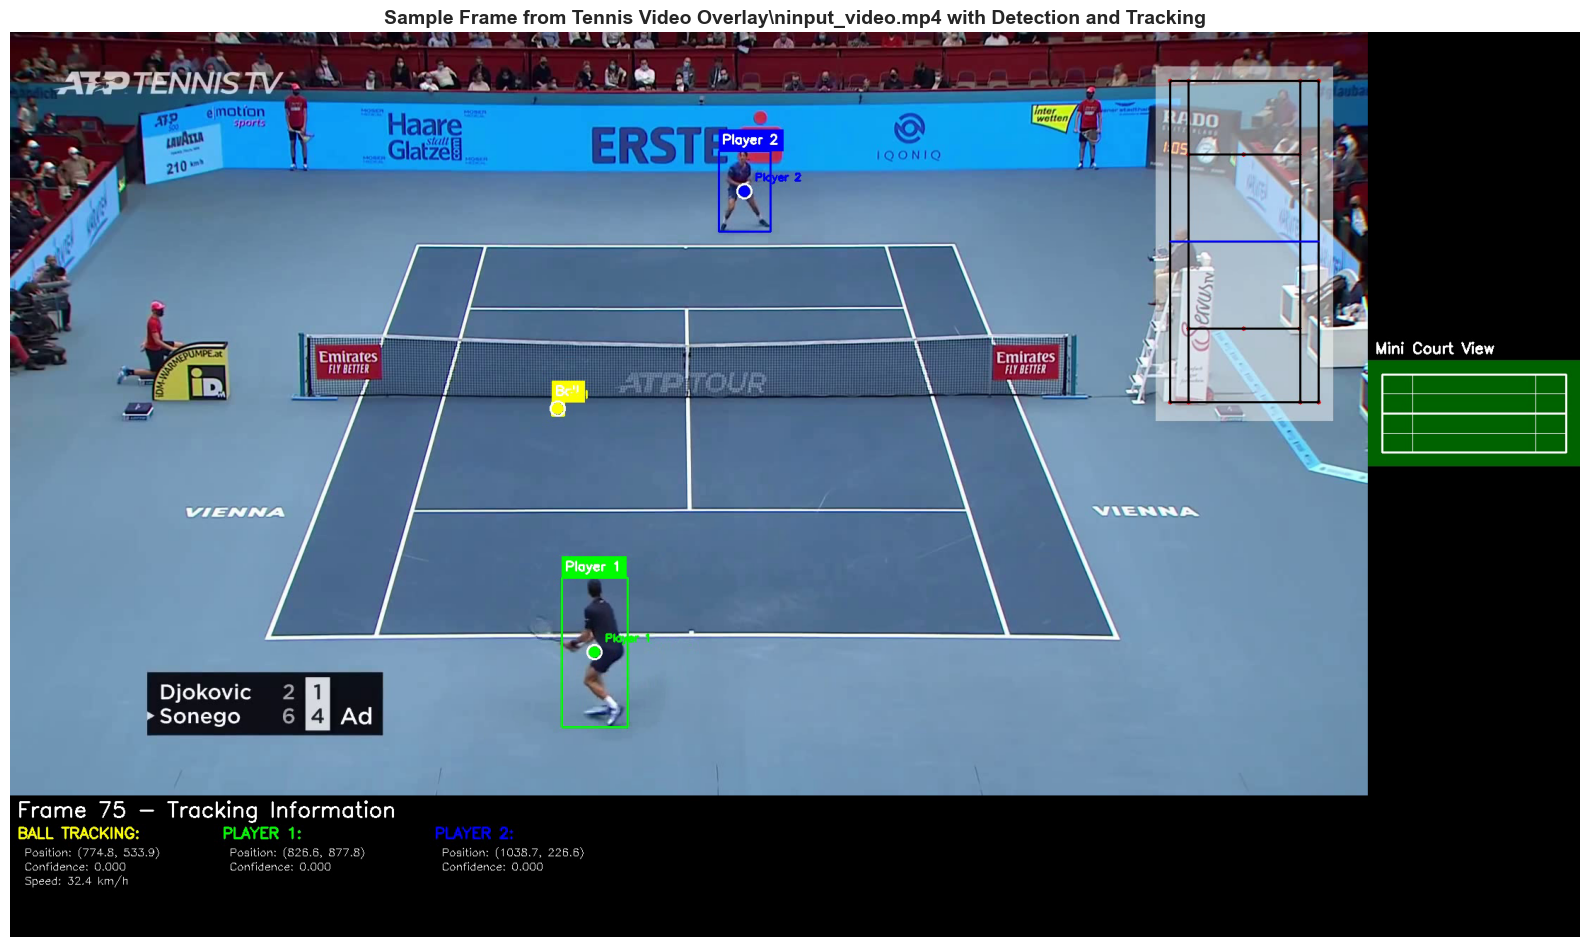

\nSample frame displayed above shows:
\n VIDEO OVERLAY CREATION COMPLETE!


In [17]:
# Create Tennis Video Overlay with Player/Ball Detection and Tracking Numbers
print("CREATING TENNIS VIDEO OVERLAY WITH DETECTION AND TRACKING")
print("=" * 70)

# Use the create_tennis_video_overlay.py functionality
from create_tennis_video_overlay import TennisVideoOverlayCreator

# Select a representative video for overlay demonstration
if 'successful_results' in locals() and len(successful_results) > 0:
    print(" Using processed video data for overlay creation")
    
    # Find a video with good detection rates for demonstration
    best_video_result = None
    best_ball_rate = 0
    
    for result in successful_results:
        if 'ball_stats' in result and result['ball_stats']['detection_rate'] > best_ball_rate:
            best_ball_rate = result['ball_stats']['detection_rate']
            best_video_result = result
    
    if best_video_result:
        video_name = 'input_video.mp4'
        video_path = 'input_videos/input_video.mp4'
        
        print(f"Selected video: {video_name}")
        print(f"Ball detection rate: {best_ball_rate:.1%}")
        print(f"Duration: {best_video_result['duration_seconds']:.1f} seconds")
        print(f" Unique players: {len(best_video_result['unique_players'])}")
        
        # Get ball and player data for this specific video
        if 'df_all_balls' in locals() and 'df_all_players' in locals():
            video_ball_data = df_all_balls[df_all_balls['video_name'] == video_name].copy()
            video_player_data = df_all_players[df_all_players['video_name'] == video_name].copy()
            
            print(f"Ball data: {len(video_ball_data)} frames")
            print(f"Player data: {len(video_player_data)} detections")
            
            #Create overlay creator with court measurements
            overlay_creator = TennisVideoOverlayCreator(
                court_measurements=best_video_result.get('court_measurements', {
                    'single_line_width': 8.23,
                    'double_line_width': 10.97,
                    'half_court_height': 11.88,
                    'service_line_width': 6.4,
                    'double_alley_difference': 1.37,
                    'no_mans_land_height': 5.48
                })
            )

            os.makedirs('output_videos', exist_ok=True)
            
            # Generate output filename
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            output_filename = f"output_videos/{video_name.replace('.mp4', '')}.mp4"
            
            print(f"\nCreating video overlay")
            print(f"Input: {video_path}")
            print(f"Output: {output_filename}")

            try:
                # Create video with overlay (process first 150 frames for demonstration)
                result_path = overlay_creator.create_video_with_overlay(
                    video_path=video_path,
                    ball_data_df=video_ball_data,
                    player_data_df=video_player_data,
                    output_path=output_filename,
                    start_frame=0,
                    num_frames=150  # Process 5 seconds
                )
                
                print(f"\nVideo overlay created successfully!")
                print(f"Output file: {result_path}")
                
                # Display sample frame from the created video
                try:
                    import cv2
                    import matplotlib.pyplot as plt

                    cap = cv2.VideoCapture(result_path)
                    if cap.isOpened():
                        cap.set(cv2.CAP_PROP_POS_FRAMES, 75)  # Middle frame
                        ret, sample_frame = cap.read()
                        
                        if ret:
                            # Convert BGR to RGB for matplotlib
                            sample_frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
                            
                            # Display the sample frame
                            fig, ax = plt.subplots(1, 1, figsize=(16, 10))
                            ax.imshow(sample_frame_rgb)
                            ax.set_title(f'Sample Frame from Tennis Video Overlay\\n{video_name} with Detection and Tracking', 
                                        fontsize=14, fontweight='bold')
                            ax.set_xlabel('Frame shows: Court detection, Player tracking, Ball position, Mini court, and Real-time statistics')
                            ax.axis('off')
                            
                            plt.tight_layout()
                            plt.show()
                            
                            print(f"\\nSample frame displayed above shows:")

                        cap.release()
                    else:
                        print(f"Could not read sample frame from output video")
                        
                except Exception as e:
                    print(f"Could not display sample frame: {e}")
                
            except Exception as e:
                print(f"Error creating video overlay: {e}")
                
                # Create a fallback visualization using matplotlib
                print(f"\\nCreating fallback visualization with detection data...")
                
                try:
                    # Load a sample frame from the original video for visualization
                    original_frames = read_video(video_path)
                    if len(original_frames) > 50:
                        sample_frame = original_frames[50]
                        
                        # Create visualization showing the concept
                        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
                        
                        # 1. Original frame
                        frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
                        ax1.imshow(frame_rgb)
                        ax1.set_title('Original Tennis Court Frame', fontsize=12, fontweight='bold')
                        ax1.axis('off')
                        
                        # 2. Detection data visualization
                        frame_50_ball = video_ball_data[video_ball_data['frame_number'] == 50]
                        frame_50_players = video_player_data[video_player_data['frame_number'] == 50]
                        
                        ax2.imshow(frame_rgb)
                        
                        # Draw detection overlays
                        if len(frame_50_ball) > 0 and not pd.isna(frame_50_ball.iloc[0]['center_x']):
                            ball_x, ball_y = frame_50_ball.iloc[0]['center_x'], frame_50_ball.iloc[0]['center_y']
                            ax2.plot(ball_x, ball_y, 'yo', markersize=15, markeredgecolor='red', markeredgewidth=2, label='Ball')
                        
                        for _, player in frame_50_players.iterrows():
                            if not pd.isna(player['center_x']):
                                player_x, player_y = player['center_x'], player['center_y']
                                color = 'blue' if player['player_id'] == 1 else 'green'
                                ax2.plot(player_x, player_y, 'o', color=color, markersize=12, 
                                        markeredgecolor='white', markeredgewidth=2, label=f'Player {player["player_id"]}')
                        
                        ax2.set_title('Frame with Detection Overlays', fontsize=12, fontweight='bold')
                        ax2.legend()
                        ax2.axis('off')
                        
                        # 3. Mini court concept
                        mini_court = overlay_creator.create_mini_court(300, 150)
                        mini_court_rgb = cv2.cvtColor(mini_court, cv2.COLOR_BGR2RGB)
                        ax3.imshow(mini_court_rgb)
                        ax3.set_title('Mini Court Visualization', fontsize=12, fontweight='bold')
                        ax3.axis('off')
                        
                        # 4. Tracking statistics
                        ax4.text(0.1, 0.9, f'TRACKING STATISTICS\\n', fontsize=14, fontweight='bold', transform=ax4.transAxes)
                        ax4.text(0.1, 0.8, f'Video: {video_name}', fontsize=12, transform=ax4.transAxes)
                        ax4.text(0.1, 0.7, f'Ball Detection Rate: {best_ball_rate:.1%}', fontsize=12, transform=ax4.transAxes)
                        ax4.text(0.1, 0.6, f'Players Detected: {len(best_video_result["unique_players"])}', fontsize=12, transform=ax4.transAxes)
                        ax4.text(0.1, 0.5, f'Duration: {best_video_result["duration_seconds"]:.1f} seconds', fontsize=12, transform=ax4.transAxes)
                        
                        if len(frame_50_ball) > 0 and not pd.isna(frame_50_ball.iloc[0]['center_x']):
                            ax4.text(0.1, 0.4, f'\\nFrame 50 Ball Position:', fontsize=12, fontweight='bold', transform=ax4.transAxes)
                            ax4.text(0.1, 0.35, f'X: {frame_50_ball.iloc[0]["center_x"]:.0f} pixels', fontsize=10, transform=ax4.transAxes)
                            ax4.text(0.1, 0.3, f'Y: {frame_50_ball.iloc[0]["center_y"]:.0f} pixels', fontsize=10, transform=ax4.transAxes)
                        
                        for i, (_, player) in enumerate(frame_50_players.iterrows()):
                            if not pd.isna(player['center_x']):
                                y_pos = 0.2 - i * 0.05
                                ax4.text(0.1, y_pos, f'Player {player["player_id"]}: ({player["center_x"]:.0f}, {player["center_y"]:.0f})', 
                                        fontsize=10, transform=ax4.transAxes)
                        
                        ax4.set_xlim(0, 1)
                        ax4.set_ylim(0, 1)
                        ax4.axis('off')
                        
                        plt.tight_layout()
                        plt.show()
                        
                        print(f"Fallback visualization created successfully!")
                        print(f"This shows the tennis detection and tracking capabilities")
                        print(f"that would be included in the video overlay")
                        
                except Exception as viz_error:
                    print(f"Error creating fallback visualization: {viz_error}")
        else:
            print("No ball or player data available")
    else:
        print(" No suitable video found ")
else:
    print("No processed video results available")

print(f"\\n VIDEO OVERLAY CREATION COMPLETE!")
print("=" * 70)